# Предсказание цены на жилье

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
import xgboost as xgb
import catboost as cb
from catboost import Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

Цветовая схема:


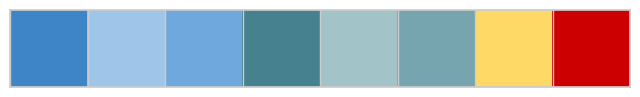

In [36]:
#whitegrid,darkgrid,white,ticks,white
sns.set_theme(style="whitegrid", font_scale=2)#, font_scale=2
plt.rcParams["figure.figsize"] = (20,10)
my_colors = ['#3d85c6', '#9fc5e8', '#6fa8dc', '#45818e', '#a2c4c9', '#76a5af', '#ffd966', '#cc0000']
#pal = sns.cubehelix_palette(10, rot=-.25, light=.7)

print("Цветовая схема:")
sns.palplot(sns.color_palette(my_colors))
plt.show()

In [4]:
#увеличиваю отображение таблиц в ячейках вывода, чтобы показывало все данные
#pd.options.display.max_rows = 500
pd.options.display.max_columns = 40

In [4]:
DATA_DIR = Path("D:/Документы/Python/ML/Симулятор/данные/HOUSE PRICE PREDICTION")

In [5]:
train_main_data  = pd.read_csv(DATA_DIR/"HW_train_main_data.csv" )
train_additional_data = pd.read_csv(DATA_DIR/"HW_train_additional_data.csv" )

In [6]:
test_main_data  = pd.read_csv(DATA_DIR/"HW_test_main_data.csv" )
test_additional_data = pd.read_csv(DATA_DIR/"HW_test_additional_data.csv" )

# EDA

In [11]:
train_main_data 

id   timestamp  full_sq  life_sq  floor  max_floor  material  \
0      30392  2014-12-30       60     36.0    6.0        9.0       1.0   
1      36540  2013-06-28       44     29.0    9.0        NaN       NaN   
2      94669  2013-09-15       62     60.0    4.0        NaN       NaN   
3      17531  2013-12-13       33     18.0    4.0        9.0       1.0   
4      32159  2014-02-13       37     14.0    1.0       17.0       1.0   
...      ...         ...      ...      ...    ...        ...       ...   
28995  85589  2013-05-08       58      NaN    2.0        NaN       NaN   
28996  11345  2014-04-12       38      NaN    9.0       17.0       1.0   
28997  55519  2013-09-23       55     30.0    9.0       16.0       1.0   
28998  17196  2013-11-19       37     19.0    3.0       16.0       5.0   
28999  97330  2014-05-03       45     20.0   12.0       17.0       6.0   

       build_year  num_room  kitch_sq  apartment condition  sub_area  \
0          1974.0       3.0       5.0                  3.0         9   
1             NaN       NaN       NaN                  NaN        19   
2             NaN       NaN       NaN                  NaN        80   
3          1970.0       1.0       6.0                  2.0        15   
4          1991.0       1.0       1.0                  2.0        74   
...           ...       ...       ...                  ...       ...   
28995         NaN       NaN       NaN                  NaN       101   
28996         NaN       1.0       1.0                  NaN       134   
28997      2002.0       2.0       8.0                  3.0        38   
28998      1979.0       1.0       9.0                  3.0        43   
28999      2011.0       1.0      10.0                  1.0       101   

           price  
0      9711800.0  
1      6643200.0  
2      5698300.0  
3      5055000.0  
4      5425000.0  
...          ...  
28995  4330300.0  
28996  4779900.0  
28997  7260000.0  
28998  6018000.0  
28999  2389000.0  

[29000 rows x 13 columns]

In [12]:
train_additional_data

id  population  indust_part  preschool_facilities  \
0      30392      155572     0.000070                     5   
1      36540      111874     0.089040                     5   
2      94669      129207     0.007720                     6   
3      17531      125354     0.265089                     4   
4      32159      111023     0.025609                     7   
...      ...         ...          ...                   ...   
28995  85589       32241     0.211401                     0   
28996  11345       75377     0.000078                     4   
28997  55519      178264     0.041116                    11   
28998  17196      153248     0.135650                     5   
28999  97330       32241     0.211401                     0   

       school_facilities  hospital_beds_raion  healthcare_facilities  \
0                      5                240.0                      1   
1                      5                  NaN                      0   
2                      6                  NaN                      0   
3                      5               1937.0                      3   
4                      7                240.0                      3   
...                  ...                  ...                    ...   
28995                  0                  NaN                      0   
28996                  4               1046.0                      3   
28997                 13                  NaN                      1   
28998                  5                350.0                      3   
28999                  0                  NaN                      0   

       university_num  sport_objects_facilities  \
0                   0                         7   
1                   0                        10   
2                   0                         4   
3                   0                         6   
4                   0                         6   
...               ...                       ...   
28995               0                         0   
28996               2                        29   
28997               0                        13   
28998               0                        11   
28999               0                         0   

       additional_education_facilities  culture_objects_facilities  \
0                                    3                           0   
1                                    3                           0   
2                                    2                           0   
3                                    4                           0   
4                                    4                           0   
...                                ...                         ...   
28995                                3                           0   
28996                               16                          10   
28997                                4                           0   
28998                                3                           0   
28999                                3                           0   

       shopping_centers_facilities  office_num  green_part  prom_part  \
0                               16           1        2.86       0.00   
1                               11           5        9.26       2.71   
2                                4           2       13.80       0.00   
3                                2           0        7.46       0.00   
4                                1           0        0.00       0.00   
...                            ...         ...         ...        ...   
28995                            1           0        9.26       7.02   
28996                           23         141       12.24       0.00   
28997                            4           4       12.32       0.00   
28998                           11           6       39.80       7.01   
28999                            1           0        1.40      16.74   

       cafe_count  church_facilities  mosque  leisure_fac

In [13]:
train_main_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29000 entries, 0 to 28999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   29000 non-null  int64  
 1   timestamp            29000 non-null  object 
 2   full_sq              29000 non-null  int64  
 3   life_sq              22935 non-null  float64
 4   floor                28843 non-null  float64
 5   max_floor            19887 non-null  float64
 6   material             19887 non-null  float64
 7   build_year           16059 non-null  float64
 8   num_room             19887 non-null  float64
 9   kitch_sq             19887 non-null  float64
 10  apartment condition  16088 non-null  float64
 11  sub_area             29000 non-null  int64  
 12  price                29000 non-null  float64
dtypes: float64(9), int64(3), object(1)
memory usage: 2.9+ MB


### есть пропуски

In [15]:
train_main_data.describe().applymap(lambda x: f"{x:0.3f}")

id    full_sq    life_sq      floor  max_floor   material  \
count  29000.000  29000.000  22935.000  28843.000  19887.000  19887.000   
mean   54932.810     55.235     34.103      7.665     12.561      1.821   
std    25981.969     38.781     20.911      5.320      6.775      1.475   
min    10001.000      0.000      0.000      0.000      0.000      1.000   
25%    32382.500     40.000     20.000      3.000      9.000      1.000   
50%    54984.500     50.000     30.000      6.000     12.000      1.000   
75%    77417.500     64.000     43.000     11.000     17.000      2.000   
max    99999.000   5329.000    802.000     77.000    117.000      6.000   

         build_year   num_room   kitch_sq apartment condition   sub_area  \
count     16059.000  19887.000  19887.000           16088.000  29000.000   
mean       3126.422      1.908      6.424               2.108     76.504   
std      158219.399      0.853     28.961               0.882     39.308   
min           0.000      0.000      0.000               1.000      0.000   
25%        1966.000      1.000      1.000               1.000     44.000   
50%        1979.000      2.000      6.000               2.000     78.000   
75%        2005.000      2.000      9.000               3.000    105.000   
max    20052009.000     19.000   2014.000              33.000    145.000   

               price  
count      29000.000  
mean     7472051.348  
std      5056735.762  
min       108500.000  
25%      4957875.000  
50%      6553400.000  
75%      8674925.000  
max    112444400.000

In [57]:
test_additional_data.describe().applymap(lambda x: f"{x:0.3f}")

id  population indust_part preschool_facilities  \
count   1000.000    1000.000    1000.000             1000.000   
mean   54982.245   85545.639       0.115                4.137   
std    25884.094   59707.296       0.118                3.067   
min    10114.000    2546.000       0.000                0.000   
25%    32023.500   21819.000       0.018                2.000   
50%    55393.500   83844.000       0.072                4.000   
75%    77627.000  123000.000       0.189                6.000   
max    99787.000  247469.000       0.522               13.000   

      school_facilities hospital_beds_raion healthcare_facilities  \
count          1000.000             544.000              1000.000   
mean              4.807            1196.754                 1.333   
std               3.537            1063.716                 1.486   
min               0.000              30.000                 0.000   
25%               2.000             350.000                 0.000   
50%               5.000            1015.000                 1.000   
75%               7.000            1894.000                 2.000   
max              14.000            4849.000                 6.000   

      university_num sport_objects_facilities additional_education_facilities  \
count       1000.000                 1000.000                        1000.000   
mean           0.137                    6.739                           2.972   
std            0.443                    6.485                           3.345   
min            0.000                    0.000                           0.000   
25%            0.000                    1.000                           1.000   
50%            0.000                    6.000                           2.000   
75%            0.000                   10.000                           4.000   
max            3.000                   29.000                          16.000   

      culture_objects_facilities shopping_centers_facilities office_num  \
count                   1000.000                    1000.000   1000.000   
mean                       0.264                       4.125      7.799   
std                        1.387                       4.643     22.011   
min                        0.000                       0.000      0.000   
25%                        0.000                       0.750      0.000   
50%                        0.000                       3.000      2.000   
75%                        0.000                       5.000      5.000   
max                       10.000                      23.000    141.000   

      green_part prom_part cafe_count church_facilities    mosque  \
count   1000.000  1000.000   1000.000          1000.000  1000.000   
mean      13.741     5.901      3.442             0.485     0.002   
std       17.049    12.129      9.690             1.851     0.045   
min        0.000     0.000      0.000             0.000     0.000   
25%        1.480     0.000      0.000             0.000     0.000   
50%        8.245     0.000      1.000             0.000     0.000   
75%       19.785     5.760      3.000             0.000     0.000   
max      100.000    94.030     72.000            15.000     1.000   

      leisure_facilities  
count           1000.000  
mean               0.084  
std                0.439  
min                0.000  
25%                0.000  
50%                0.000  
75%                0.000  
max                8.000

### есть большие выбросы

In [7]:
train_main_data['timestamp'] = pd.to_datetime(train_main_data['timestamp'])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


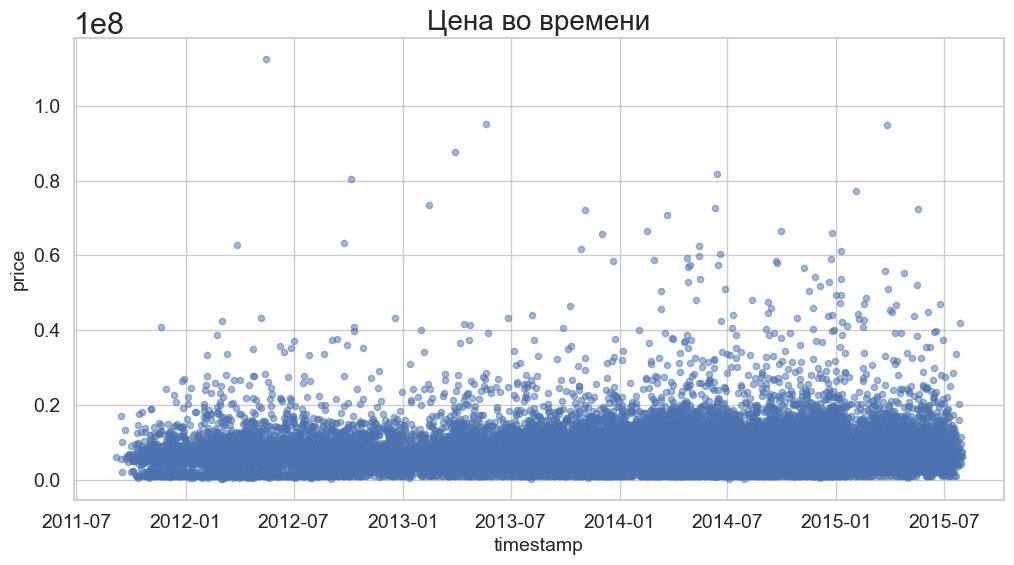

In [50]:
train_main_data.plot(x='timestamp', y='price', kind='scatter', alpha=0.5, figsize=(12, 6), fontsize=14);
plt.title('Цена во времени', fontsize=20)
plt.xlabel('timestamp', fontsize=14)
plt.ylabel('price', fontsize=14)
plt.show()

C:\Users\keybi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

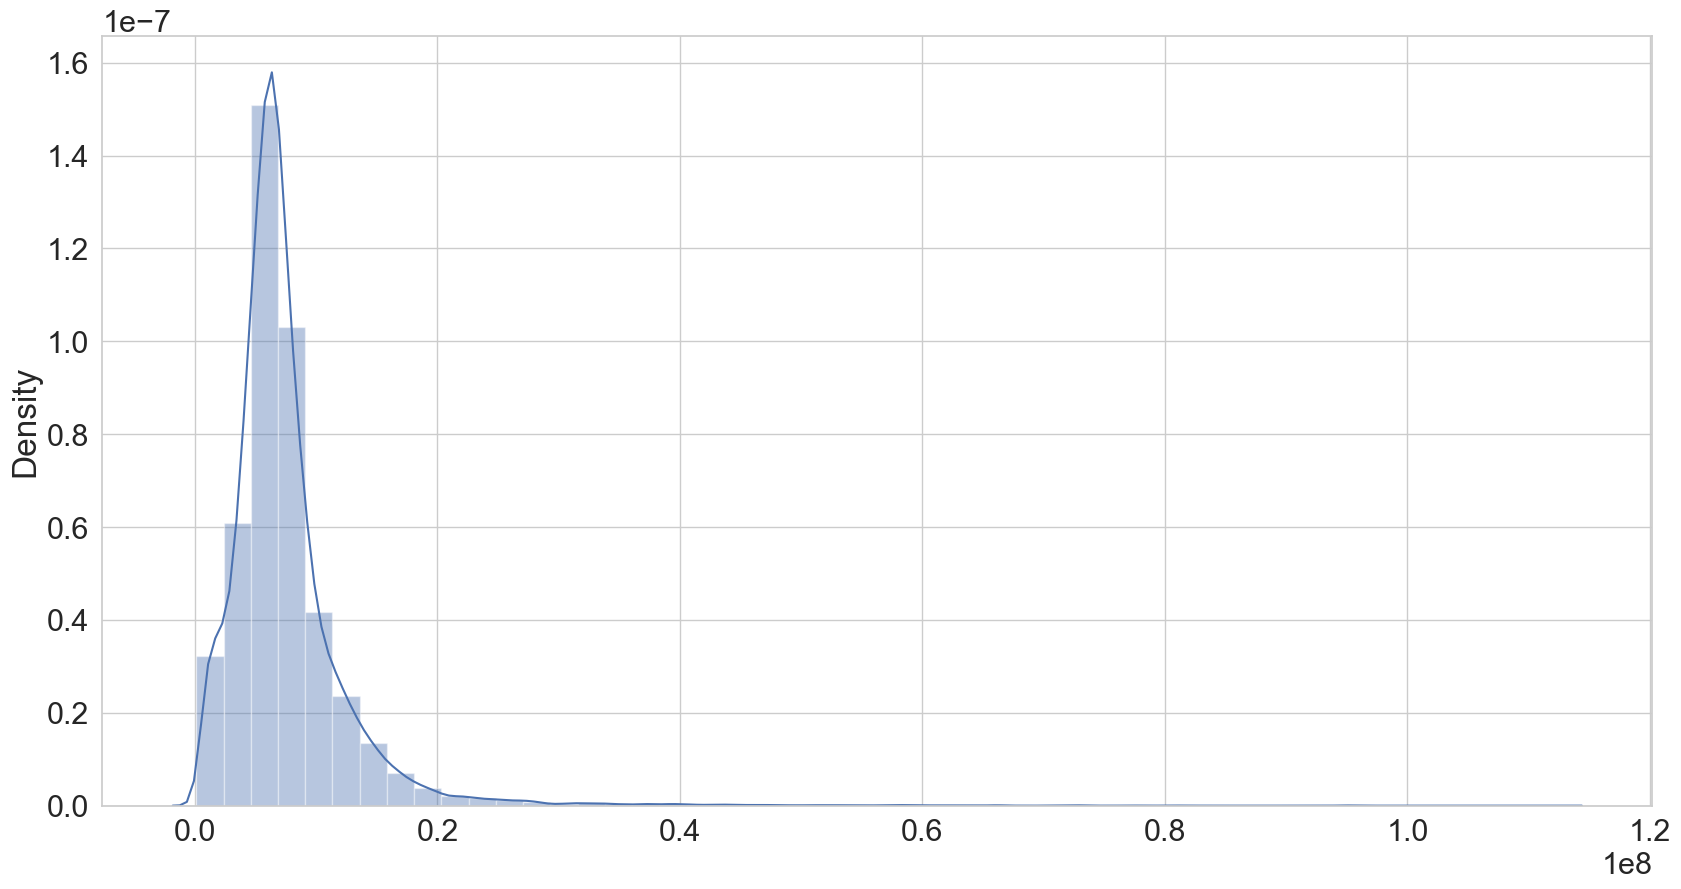

In [51]:
sns.distplot(train_main_data.price.values)

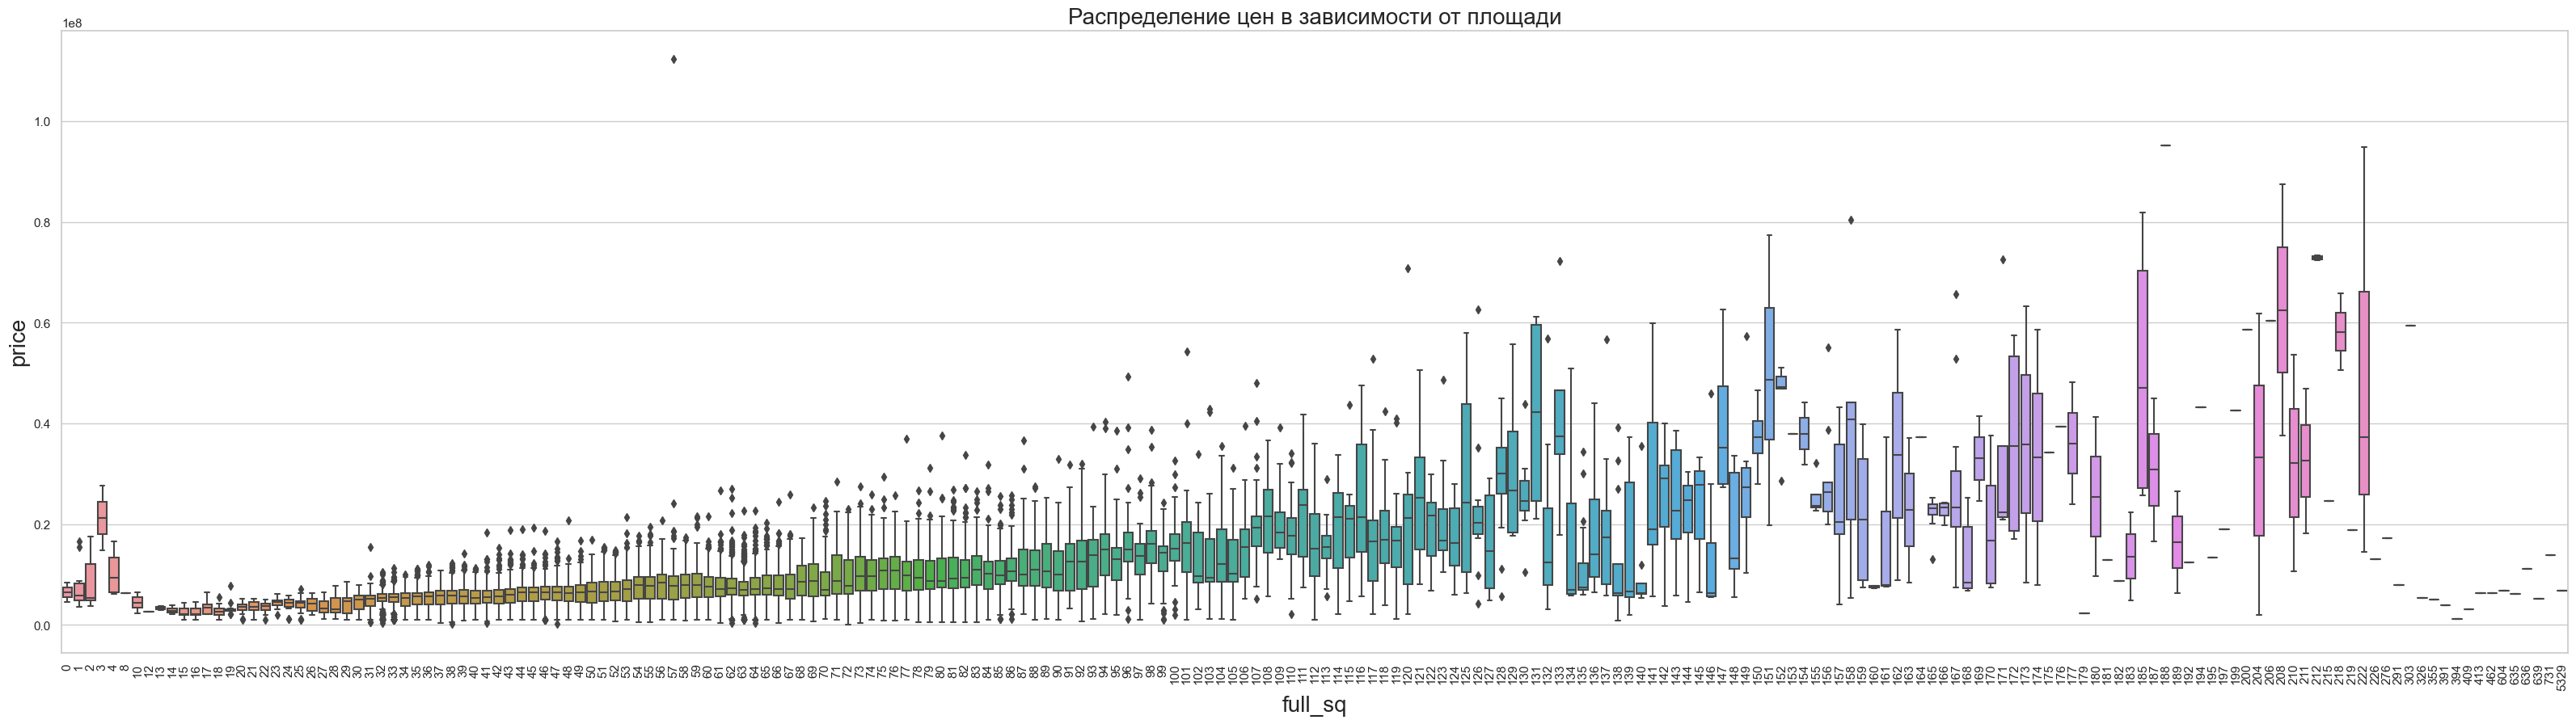

In [35]:
plt.figure(figsize=(40, 10));
sns.boxplot(x='full_sq', y='price', data=train_main_data);
plt.title('Распределение цен в зависимости от площади', fontsize=20)
plt.ylabel('price', fontsize=20)
plt.xlabel('full_sq', fontsize=20)
plt.xticks(rotation = 'vertical')
plt.show()

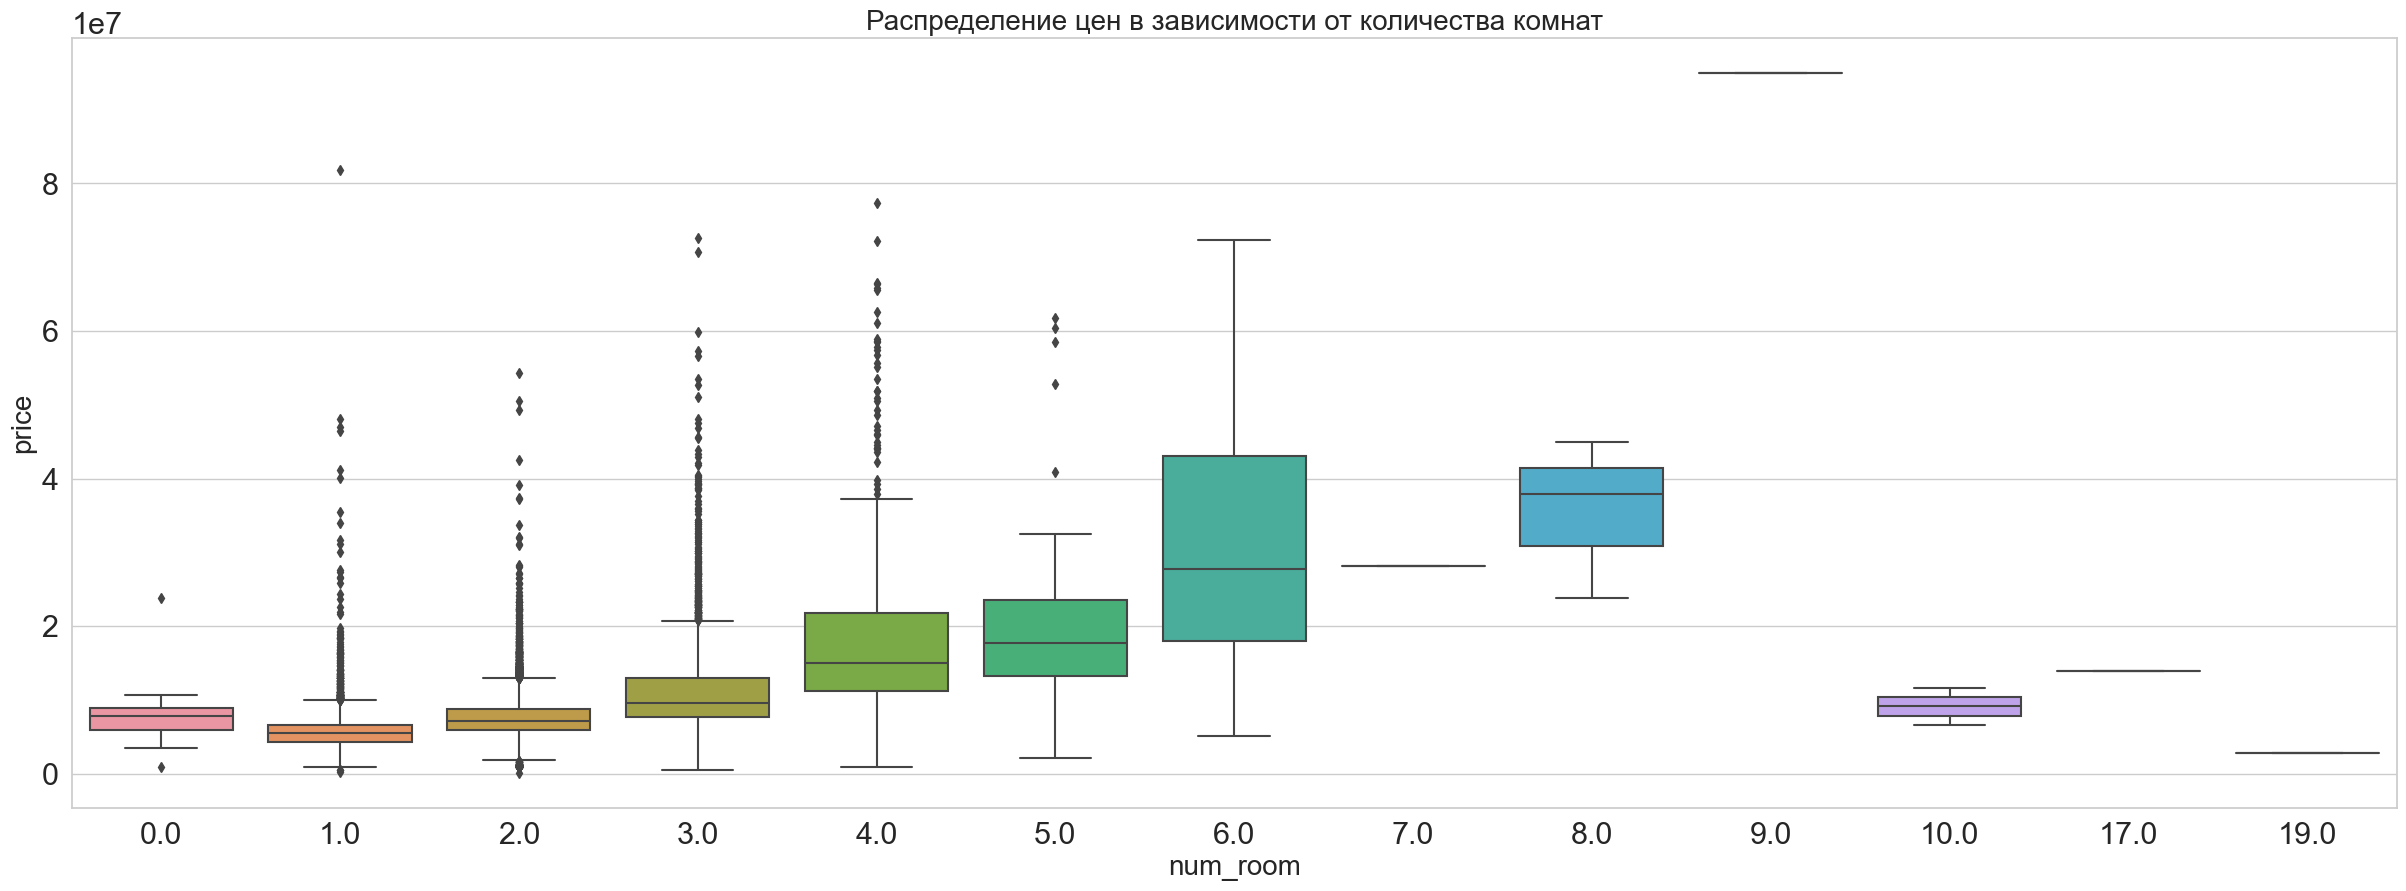

In [8]:
plt.figure(figsize=(30, 10));
sns.boxplot(x='num_room', y='price', data=train_main_data);
plt.title('Распределение цен в зависимости от количества комнат', fontsize=20)
plt.ylabel('price', fontsize=20)
plt.xlabel('num_room', fontsize=20)
plt.show()

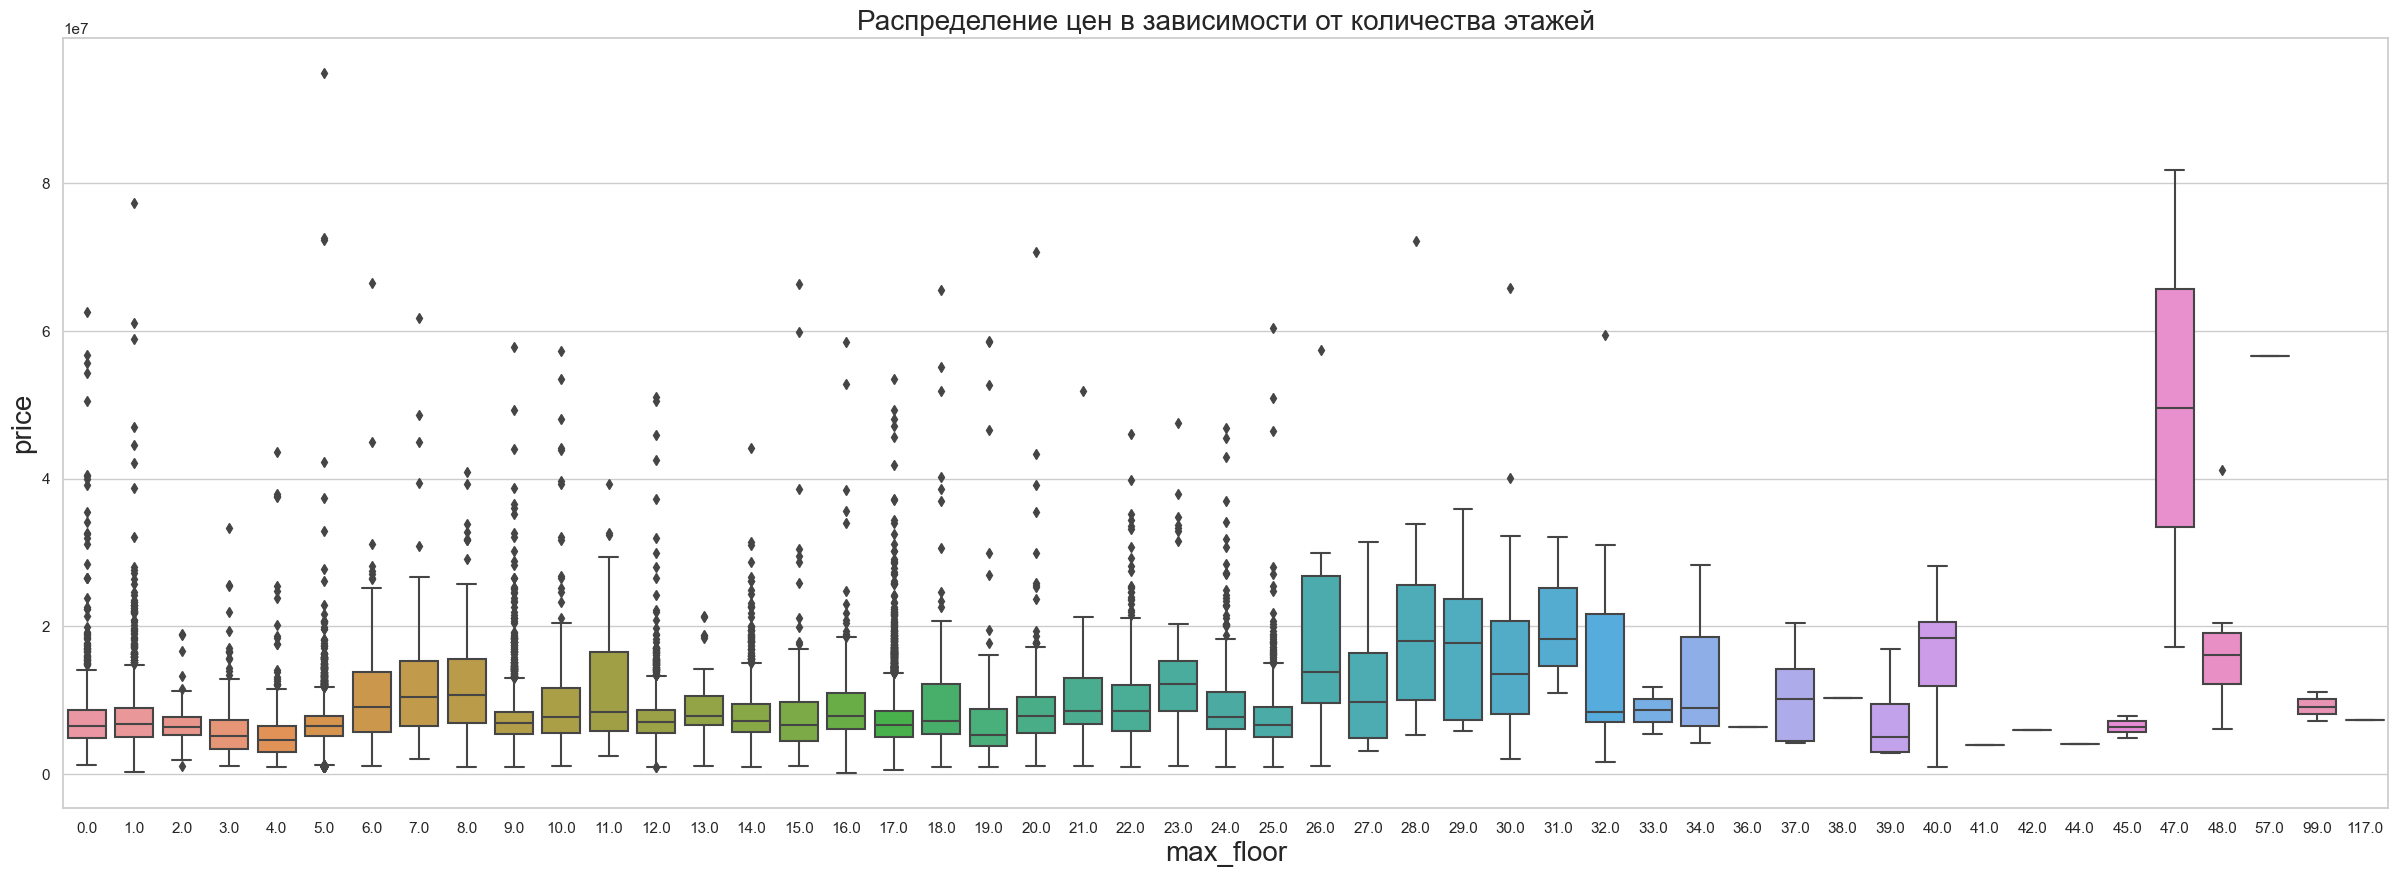

In [11]:
plt.figure(figsize=(30, 10));
sns.boxplot(x='max_floor', y='price', data=train_main_data);
plt.title('Распределение цен в зависимости от количества этажей', fontsize=20)
plt.ylabel('price', fontsize=20)
plt.xlabel('max_floor', fontsize=20)
plt.show()

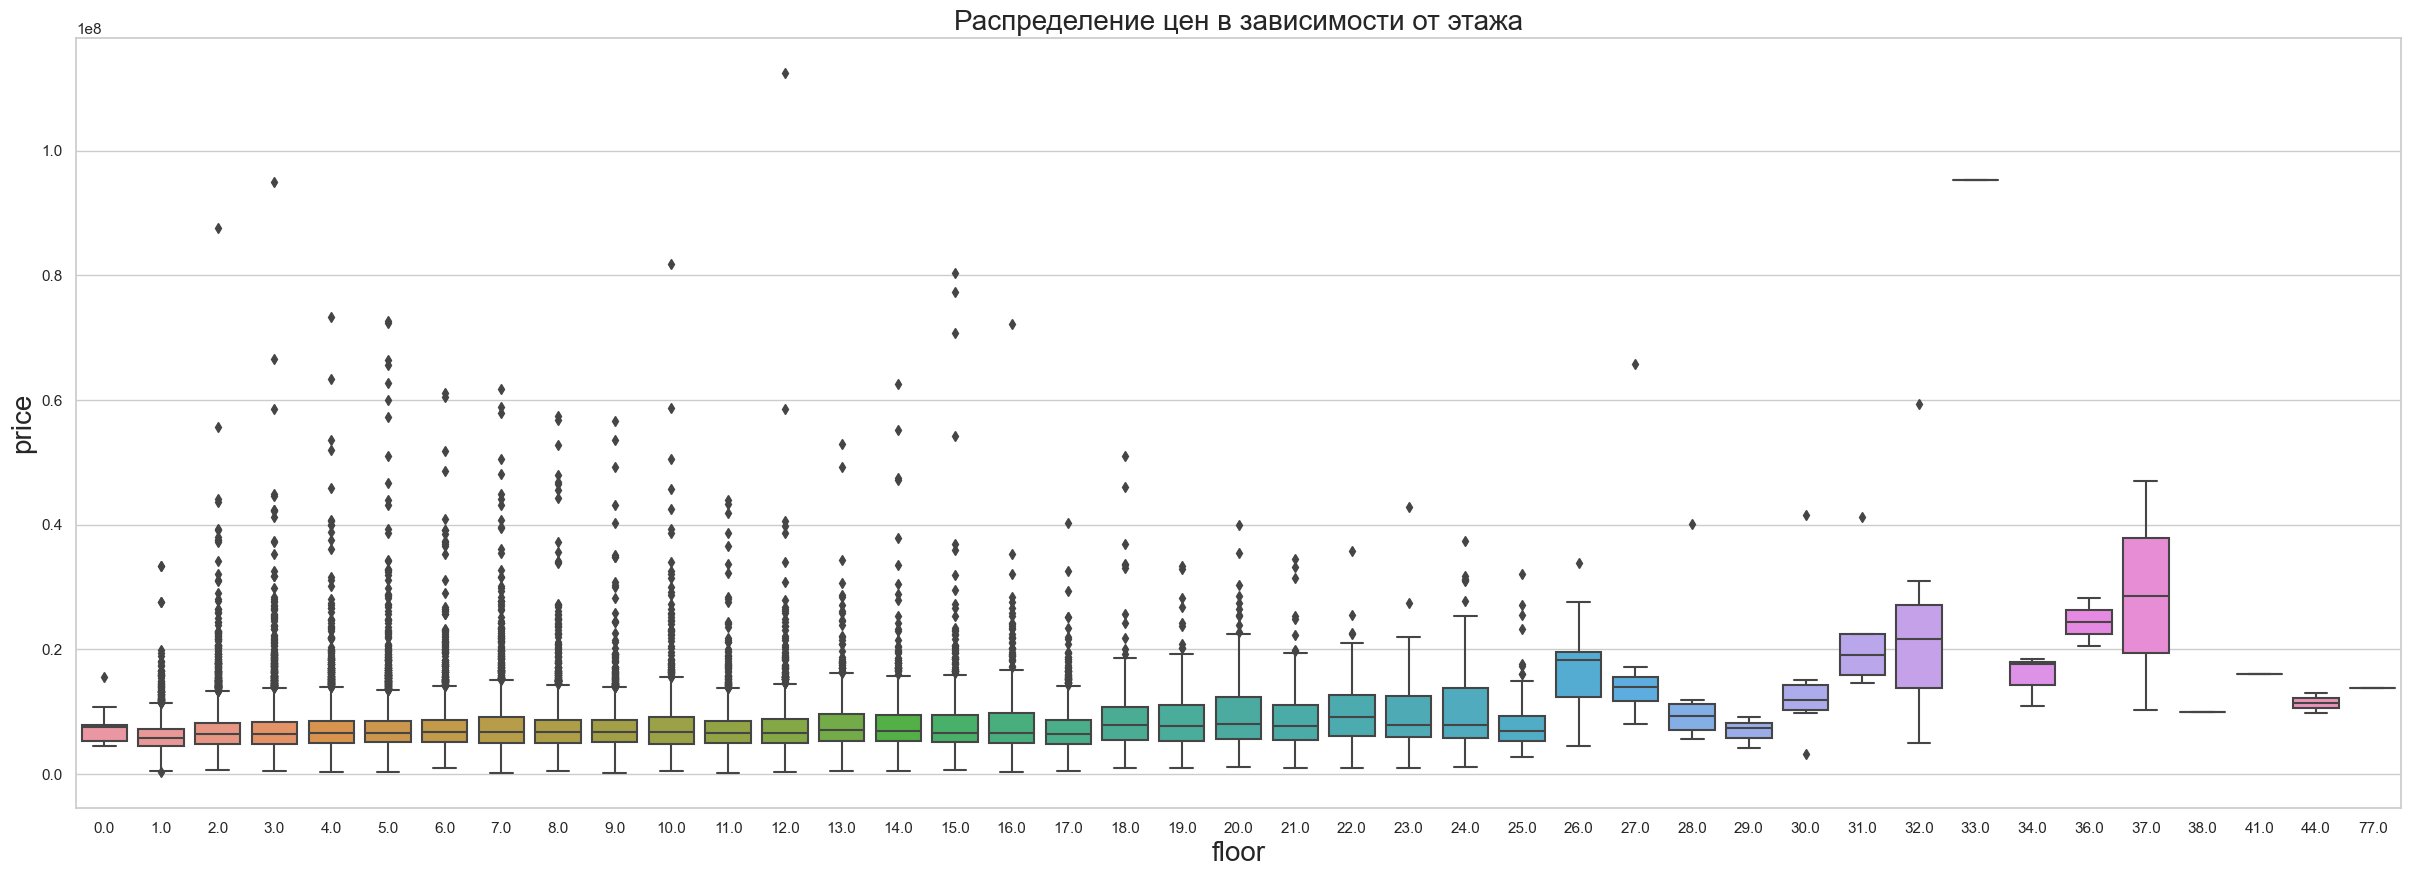

In [12]:
plt.figure(figsize=(30, 10));
sns.boxplot(x='floor', y='price', data=train_main_data);
plt.title('Распределение цен в зависимости от этажа', fontsize=20)
plt.ylabel('price', fontsize=20)
plt.xlabel('floor', fontsize=20)
plt.show()

In [8]:
train_additional_data_w_price = train_additional_data.merge(train_main_data[['id','price']], how= 'inner', on = 'id')

In [41]:
train_additional_data_w_price

id  population  indust_part  preschool_facilities  \
1      36540      111874     0.089040                     5   
2      94669      129207     0.007720                     6   
3      17531      125354     0.265089                     4   
4      32159      111023     0.025609                     7   
5      63050       75377     0.000078                     4   
...      ...         ...          ...                   ...   
28995  85589       32241     0.211401                     0   
28996  11345       75377     0.000078                     4   
28997  55519      178264     0.041116                    11   
28998  17196      153248     0.135650                     5   
28999  97330       32241     0.211401                     0   

       school_facilities  hospital_beds_raion  healthcare_facilities  \
1                      5                  NaN                      0   
2                      6                  NaN                      0   
3                      5               1937.0                      3   
4                      7                240.0                      3   
5                      4               1046.0                      3   
...                  ...                  ...                    ...   
28995                  0                  NaN                      0   
28996                  4               1046.0                      3   
28997                 13                  NaN                      1   
28998                  5                350.0                      3   
28999                  0                  NaN                      0   

       university_num  sport_objects_facilities  \
1                   0                        10   
2                   0                         4   
3                   0                         6   
4                   0                         6   
5                   2                        29   
...               ...                       ...   
28995               0                         0   
28996               2                        29   
28997               0                        13   
28998               0                        11   
28999               0                         0   

       additional_education_facilities  culture_objects_facilities  \
1                                    3                           0   
2                                    2                           0   
3                                    4                           0   
4                                    4                           0   
5                                   16                          10   
...                                ...                         ...   
28995                                3                           0   
28996                               16                          10   
28997                                4                           0   
28998                                3                           0   
28999                                3                           0   

       shopping_centers_facilities  office_num  green_part  prom_part  \
1                               11           5        9.26       2.71   
2                                4           2       13.80       0.00   
3                                2           0        7.46       0.00   
4                                1           0        0.00       0.00   
5                               23         141       12.24       0.00   
...                            ...         ...         ...        ...   
28995                            1           0        9.26       7.02   
28996                           23         141       12.24       0.00   
28997                            4           4       12.32       0.00   
28998                           11           6       39.80       7.01   
28999                            1           0        1.40      16.74   

       cafe_count  church_facilities  mosque  leisure_fac

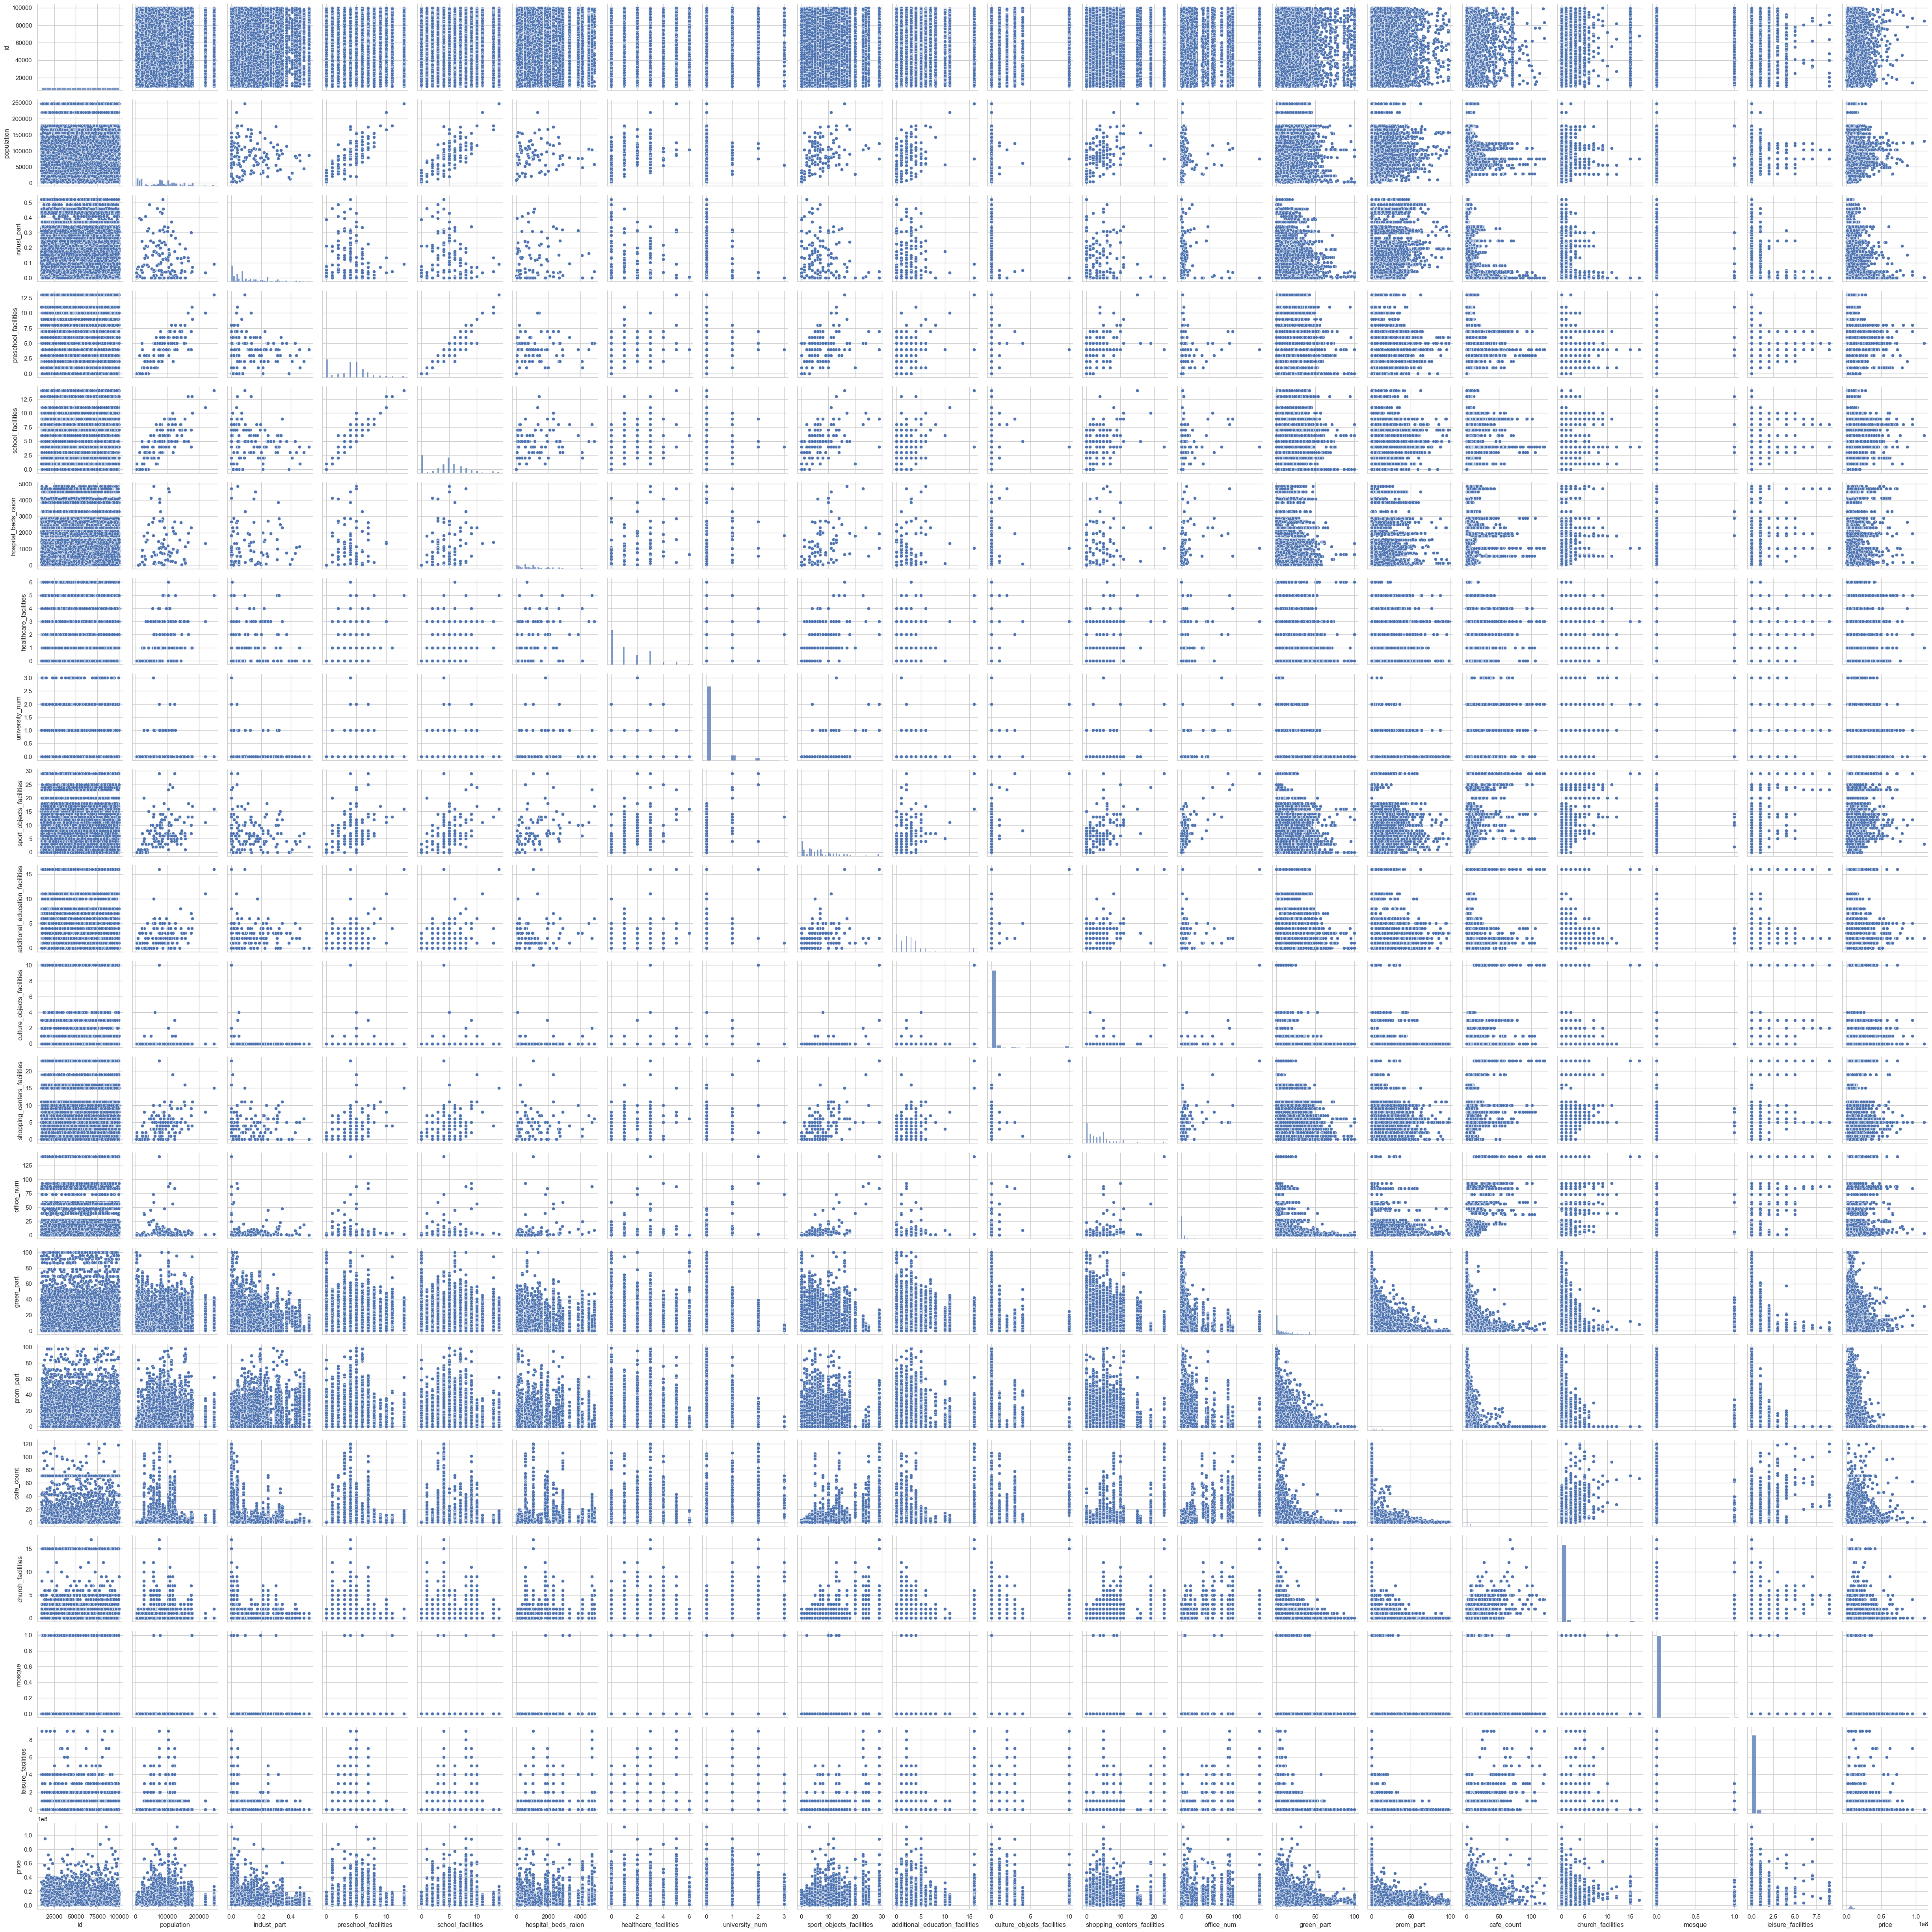

In [42]:
sns.pairplot(train_additional_data_w_price)

In [9]:
full_train_data = train_main_data.merge(train_additional_data, how= 'inner', on = 'id')

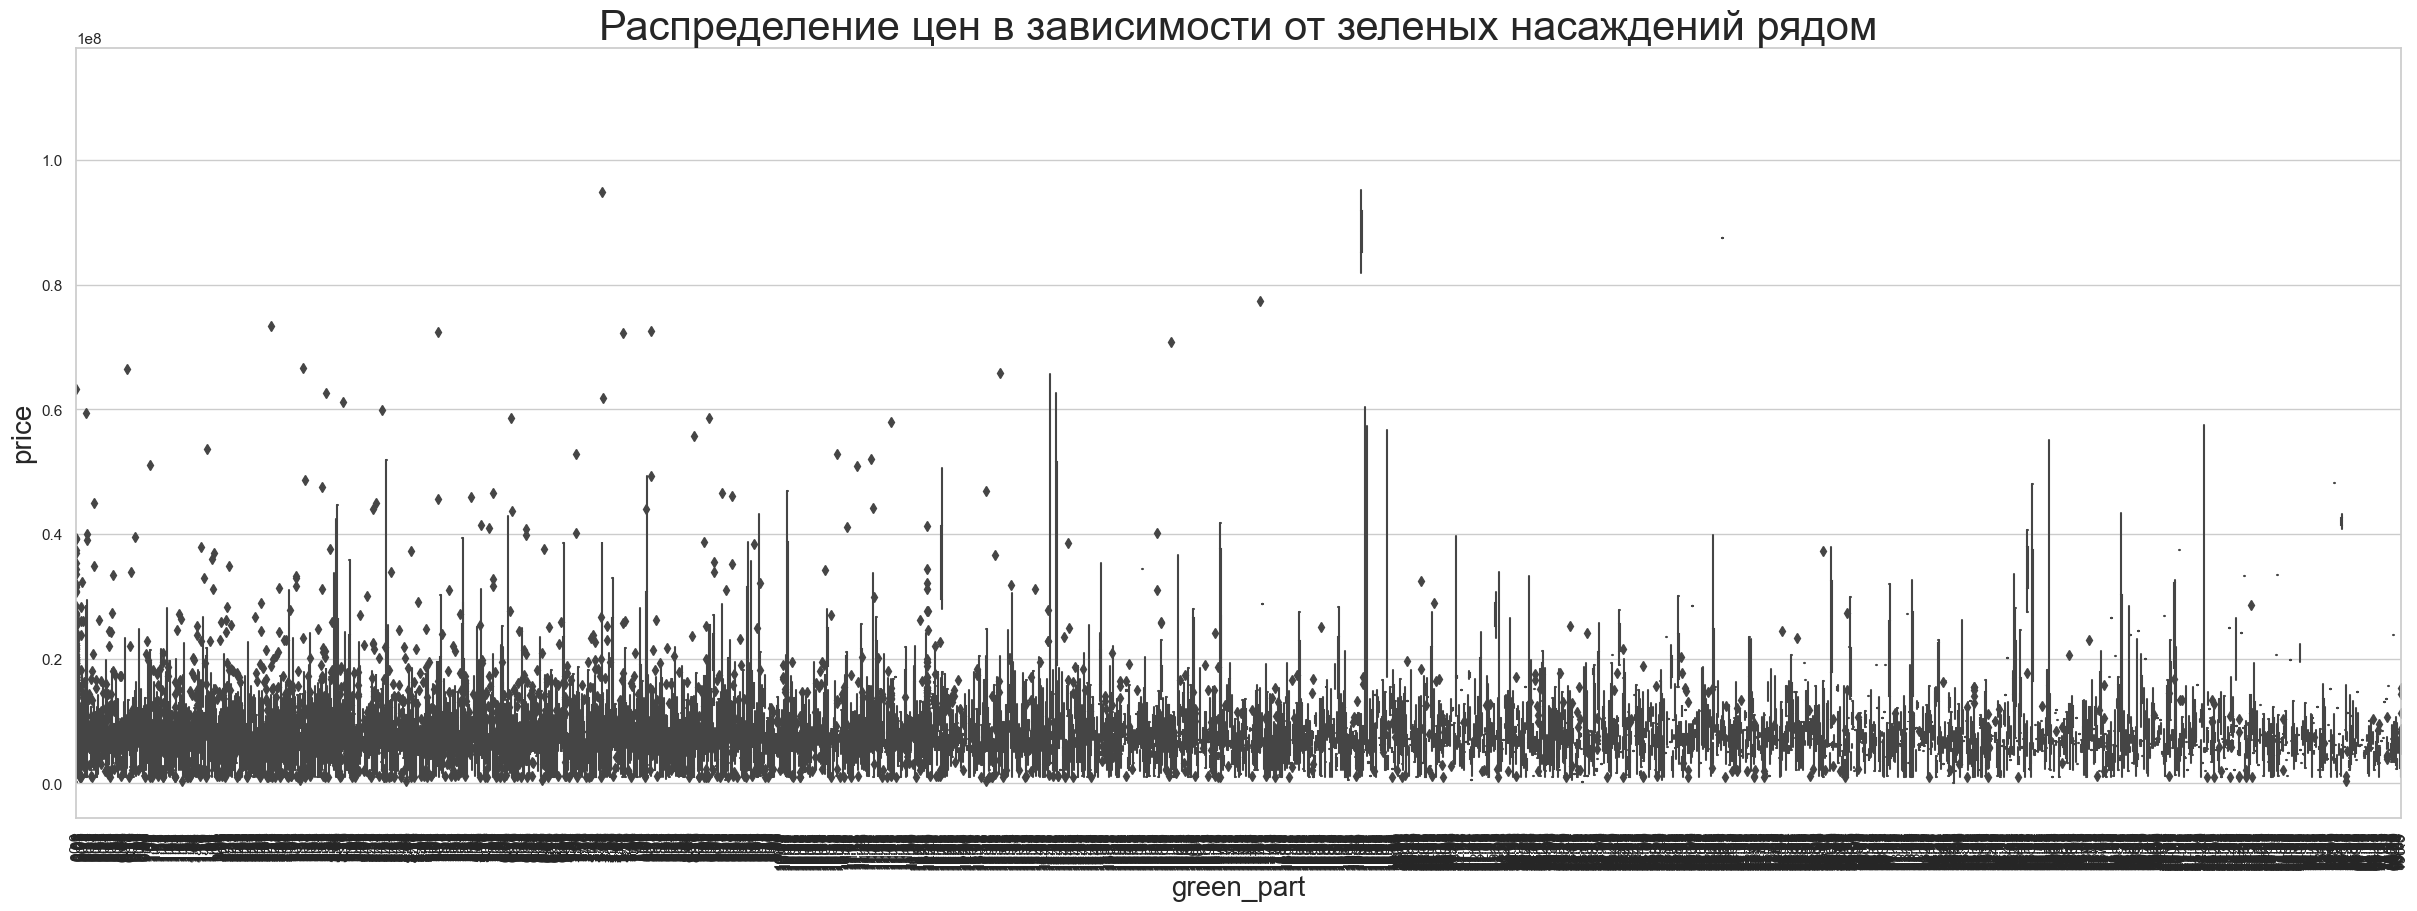

In [33]:
plt.figure(figsize=(30, 10));
sns.boxplot(x='green_part', y='price', data=full_train_data);
plt.title('Распределение цен в зависимости от зеленых насаждений рядом', fontsize=30)
plt.ylabel('price', fontsize=20)
plt.xlabel('green_part', fontsize=20)
plt.xticks(rotation = 'vertical')
plt.show()

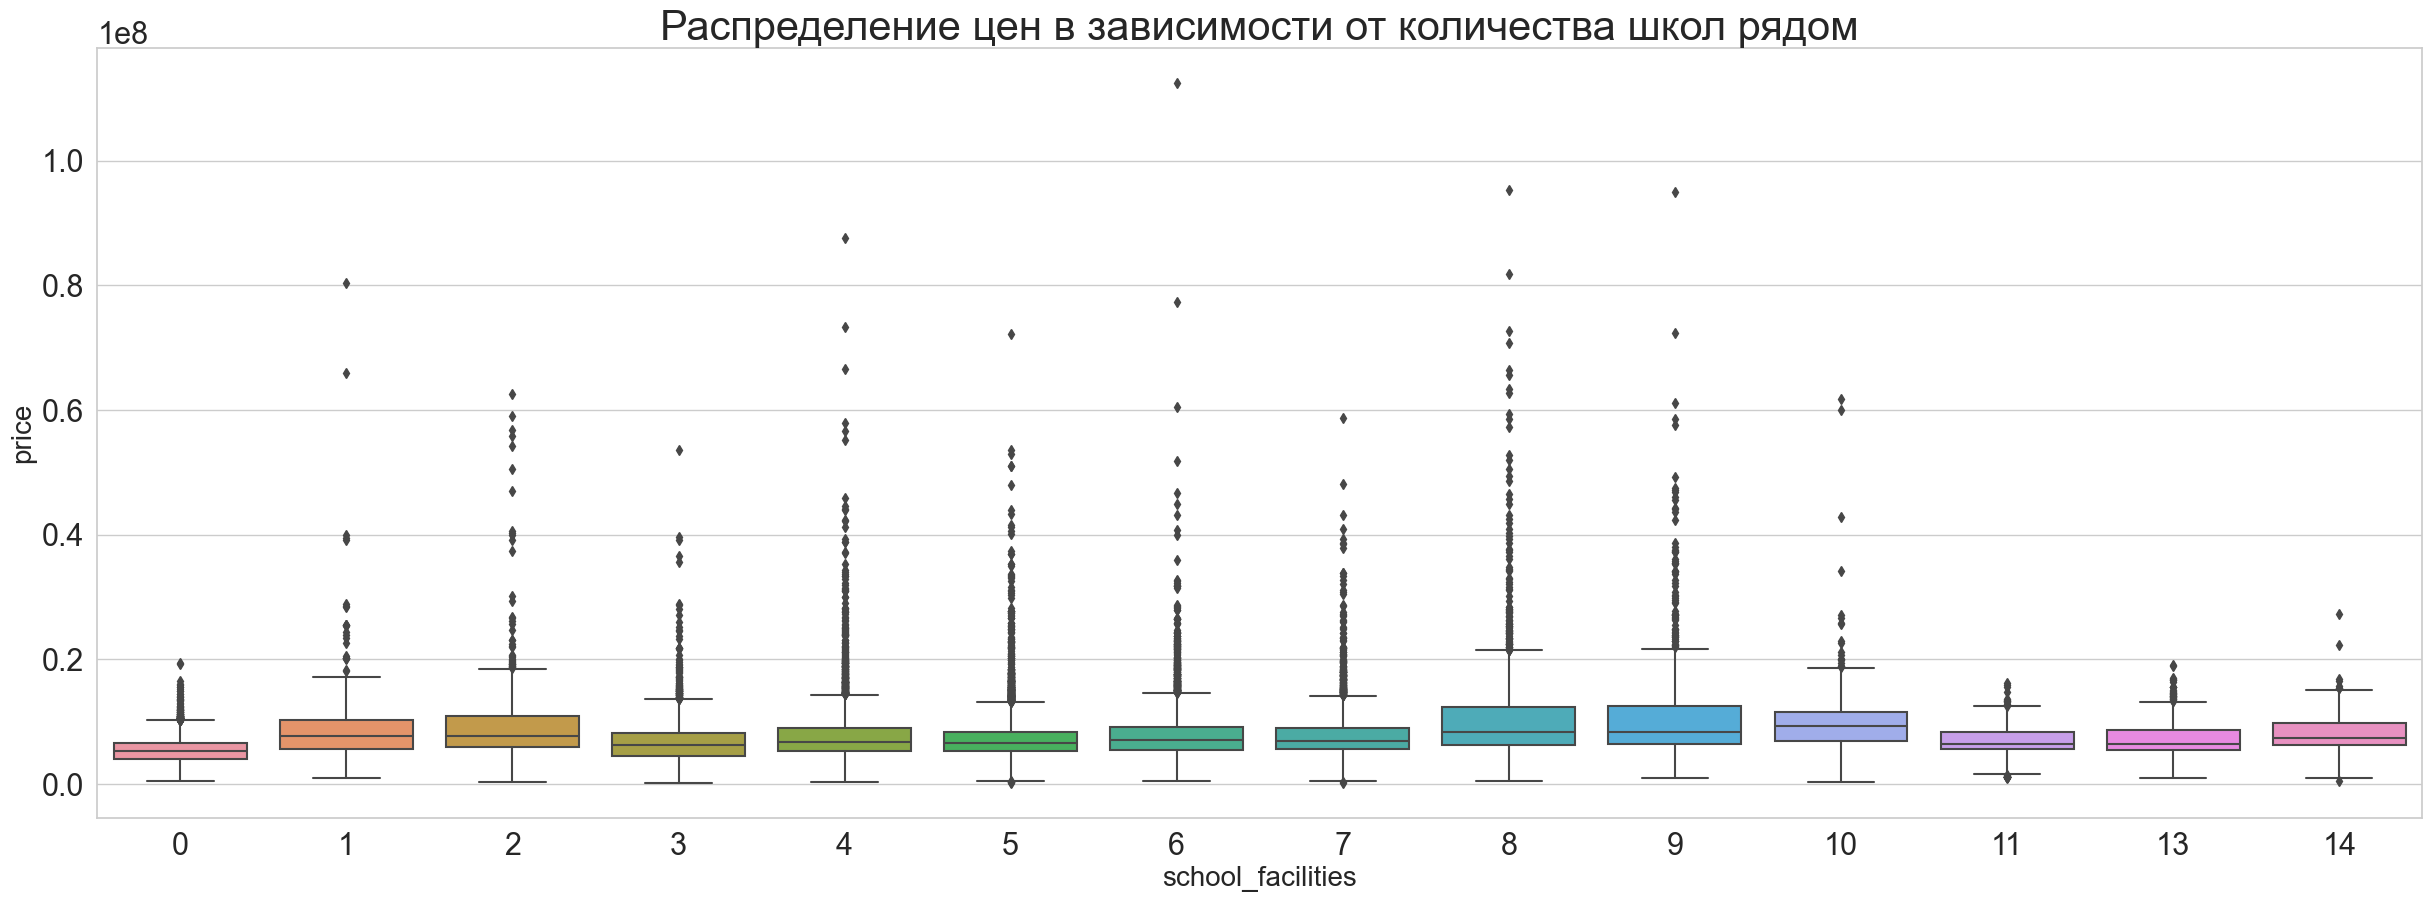

In [21]:
plt.figure(figsize=(30, 10));
sns.boxplot(x='school_facilities', y='price', data=full_train_data);
plt.title('Распределение цен в зависимости от количества школ рядом', fontsize=30)
plt.ylabel('price', fontsize=20)
plt.xlabel('school_facilities', fontsize=20)
plt.show()

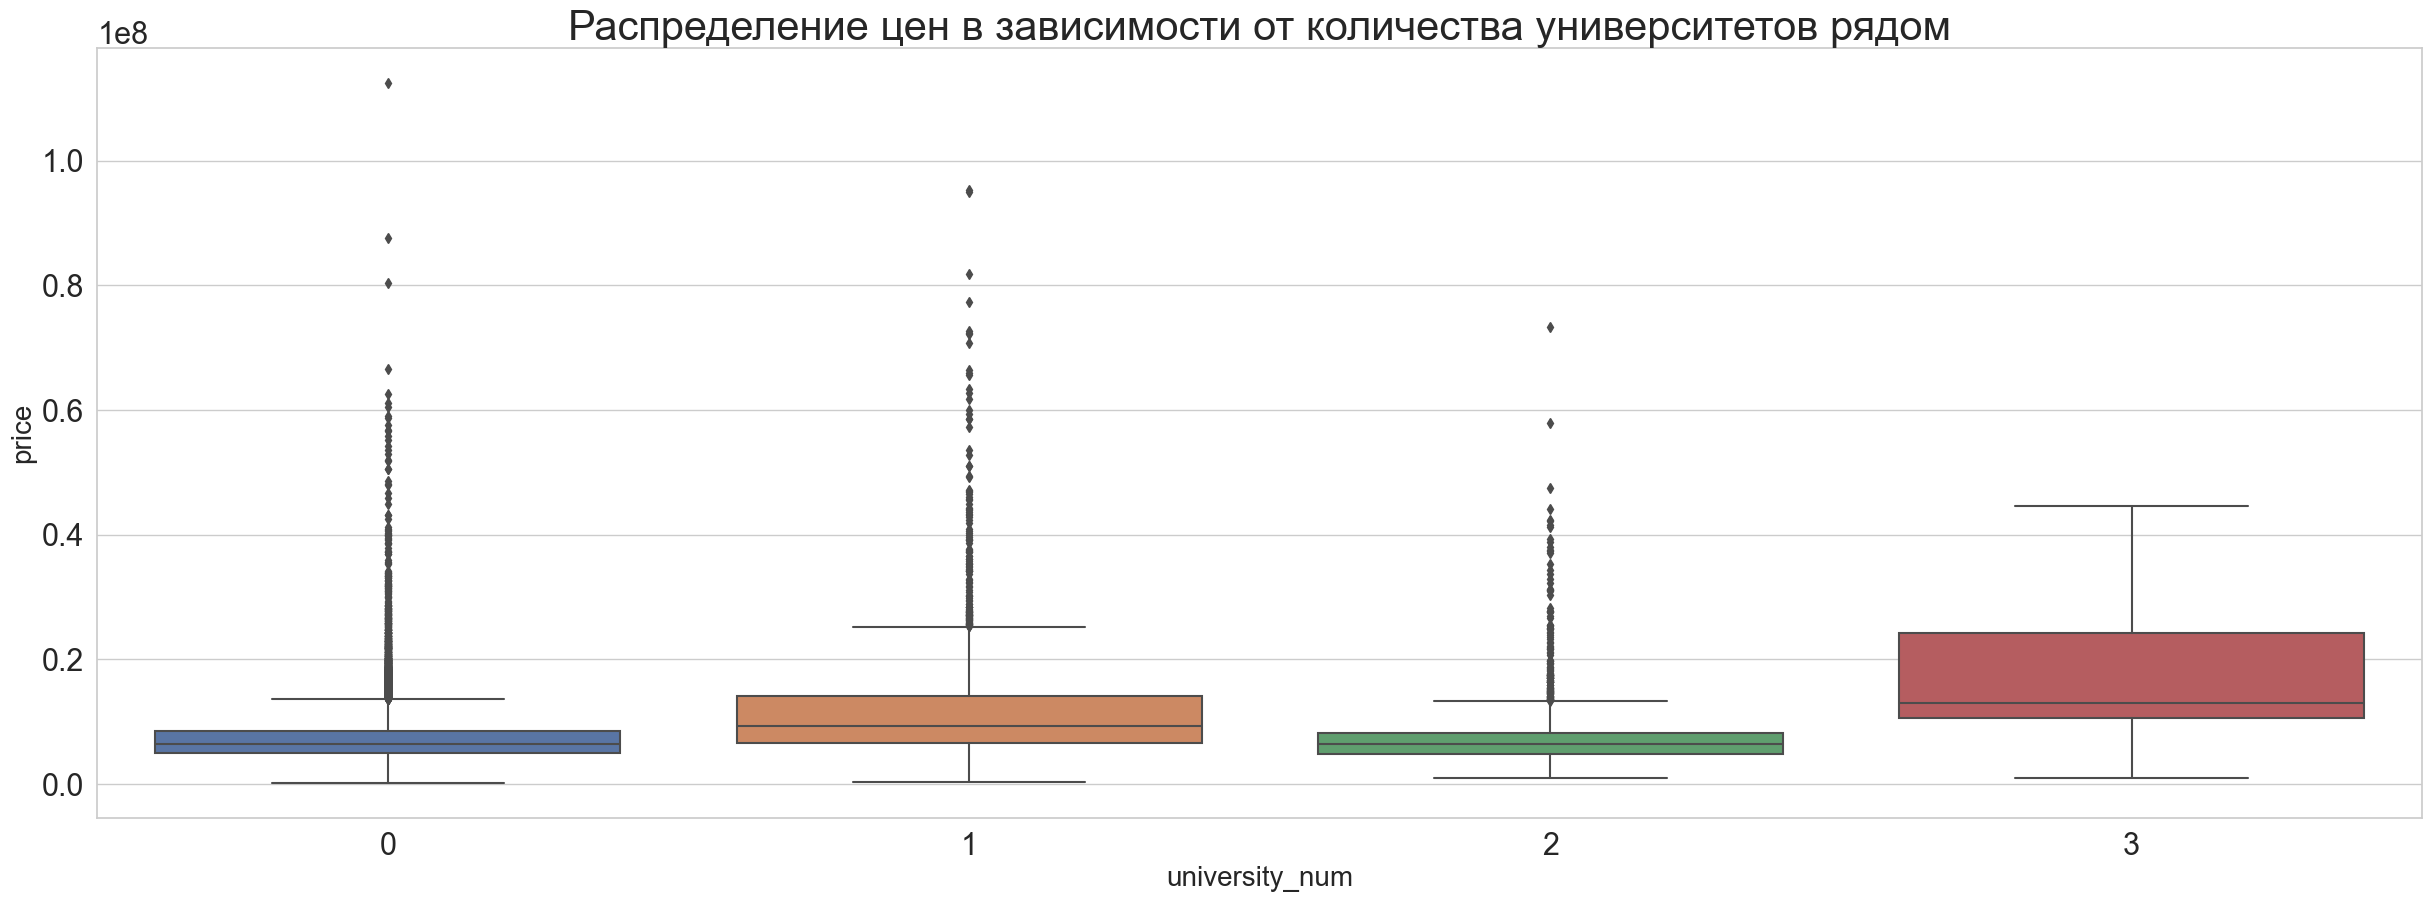

In [22]:
plt.figure(figsize=(30, 10));
sns.boxplot(x='university_num', y='price', data=full_train_data);
plt.title('Распределение цен в зависимости от количества университетов рядом', fontsize=30)
plt.ylabel('price', fontsize=20)
plt.xlabel('university_num', fontsize=20)
plt.show()

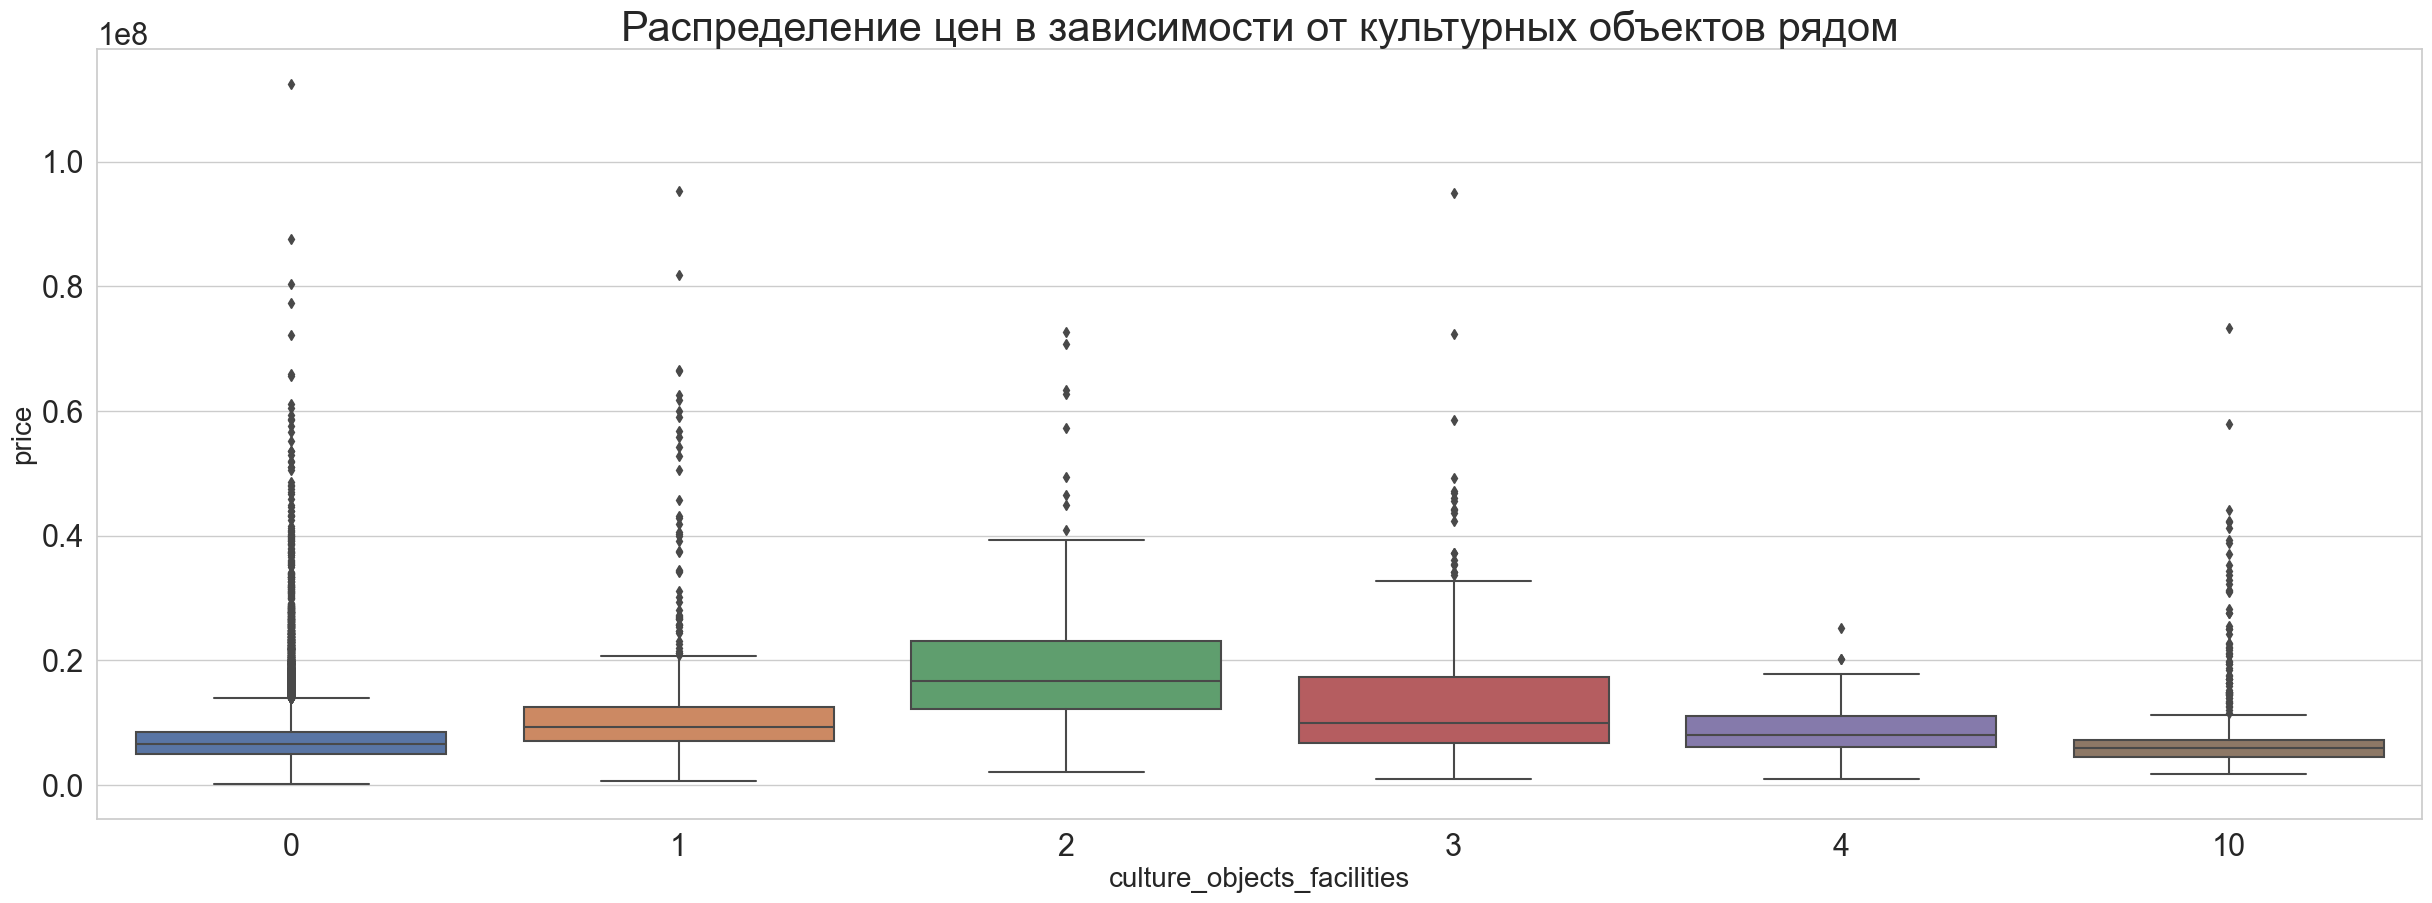

In [23]:
plt.figure(figsize=(30, 10));
sns.boxplot(x='culture_objects_facilities', y='price', data=full_train_data);
plt.title('Распределение цен в зависимости от культурных объектов рядом', fontsize=30)
plt.ylabel('price', fontsize=20)
plt.xlabel('culture_objects_facilities', fontsize=20)
plt.show()

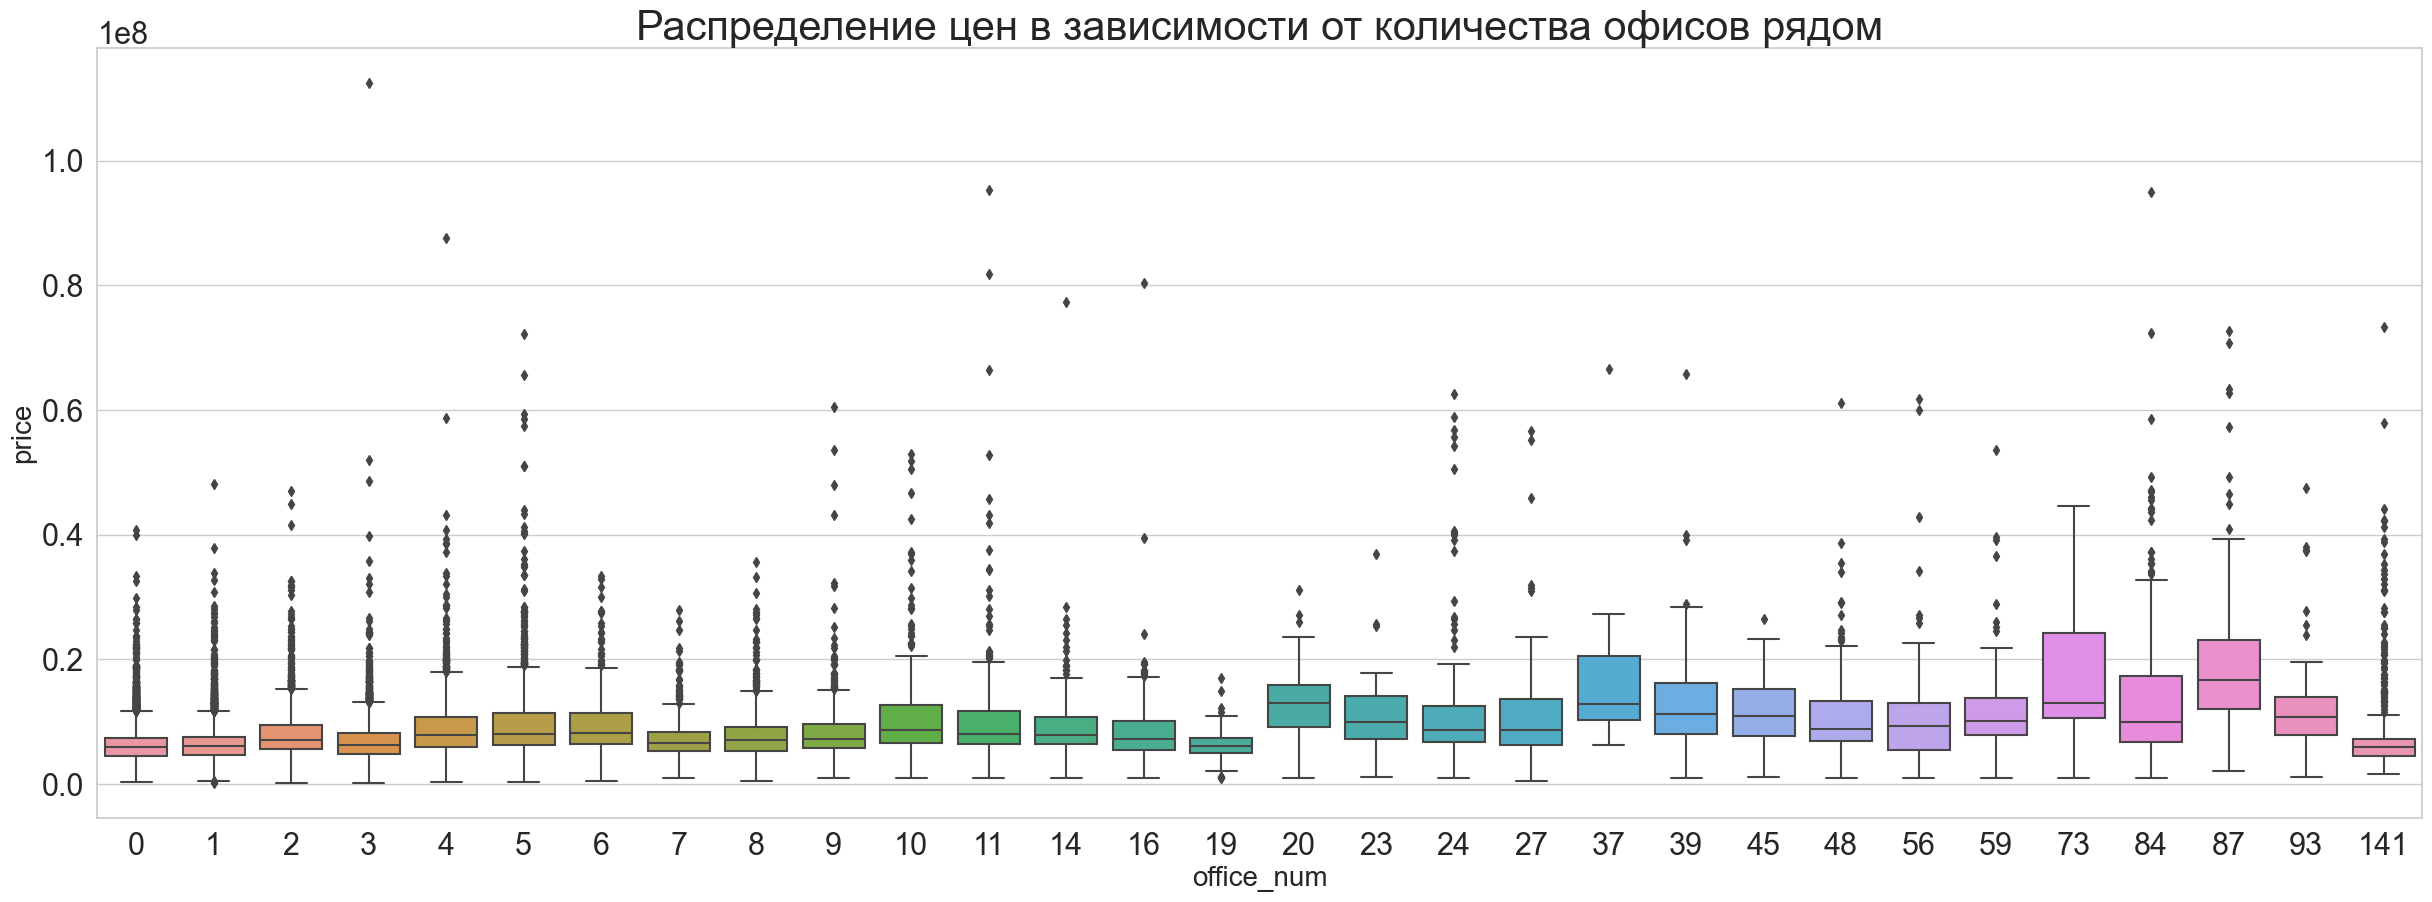

In [24]:
plt.figure(figsize=(30, 10));
sns.boxplot(x='office_num', y='price', data=full_train_data);
plt.title('Распределение цен в зависимости от количества офисов рядом', fontsize=30)
plt.ylabel('price', fontsize=20)
plt.xlabel('office_num', fontsize=20)
plt.show()

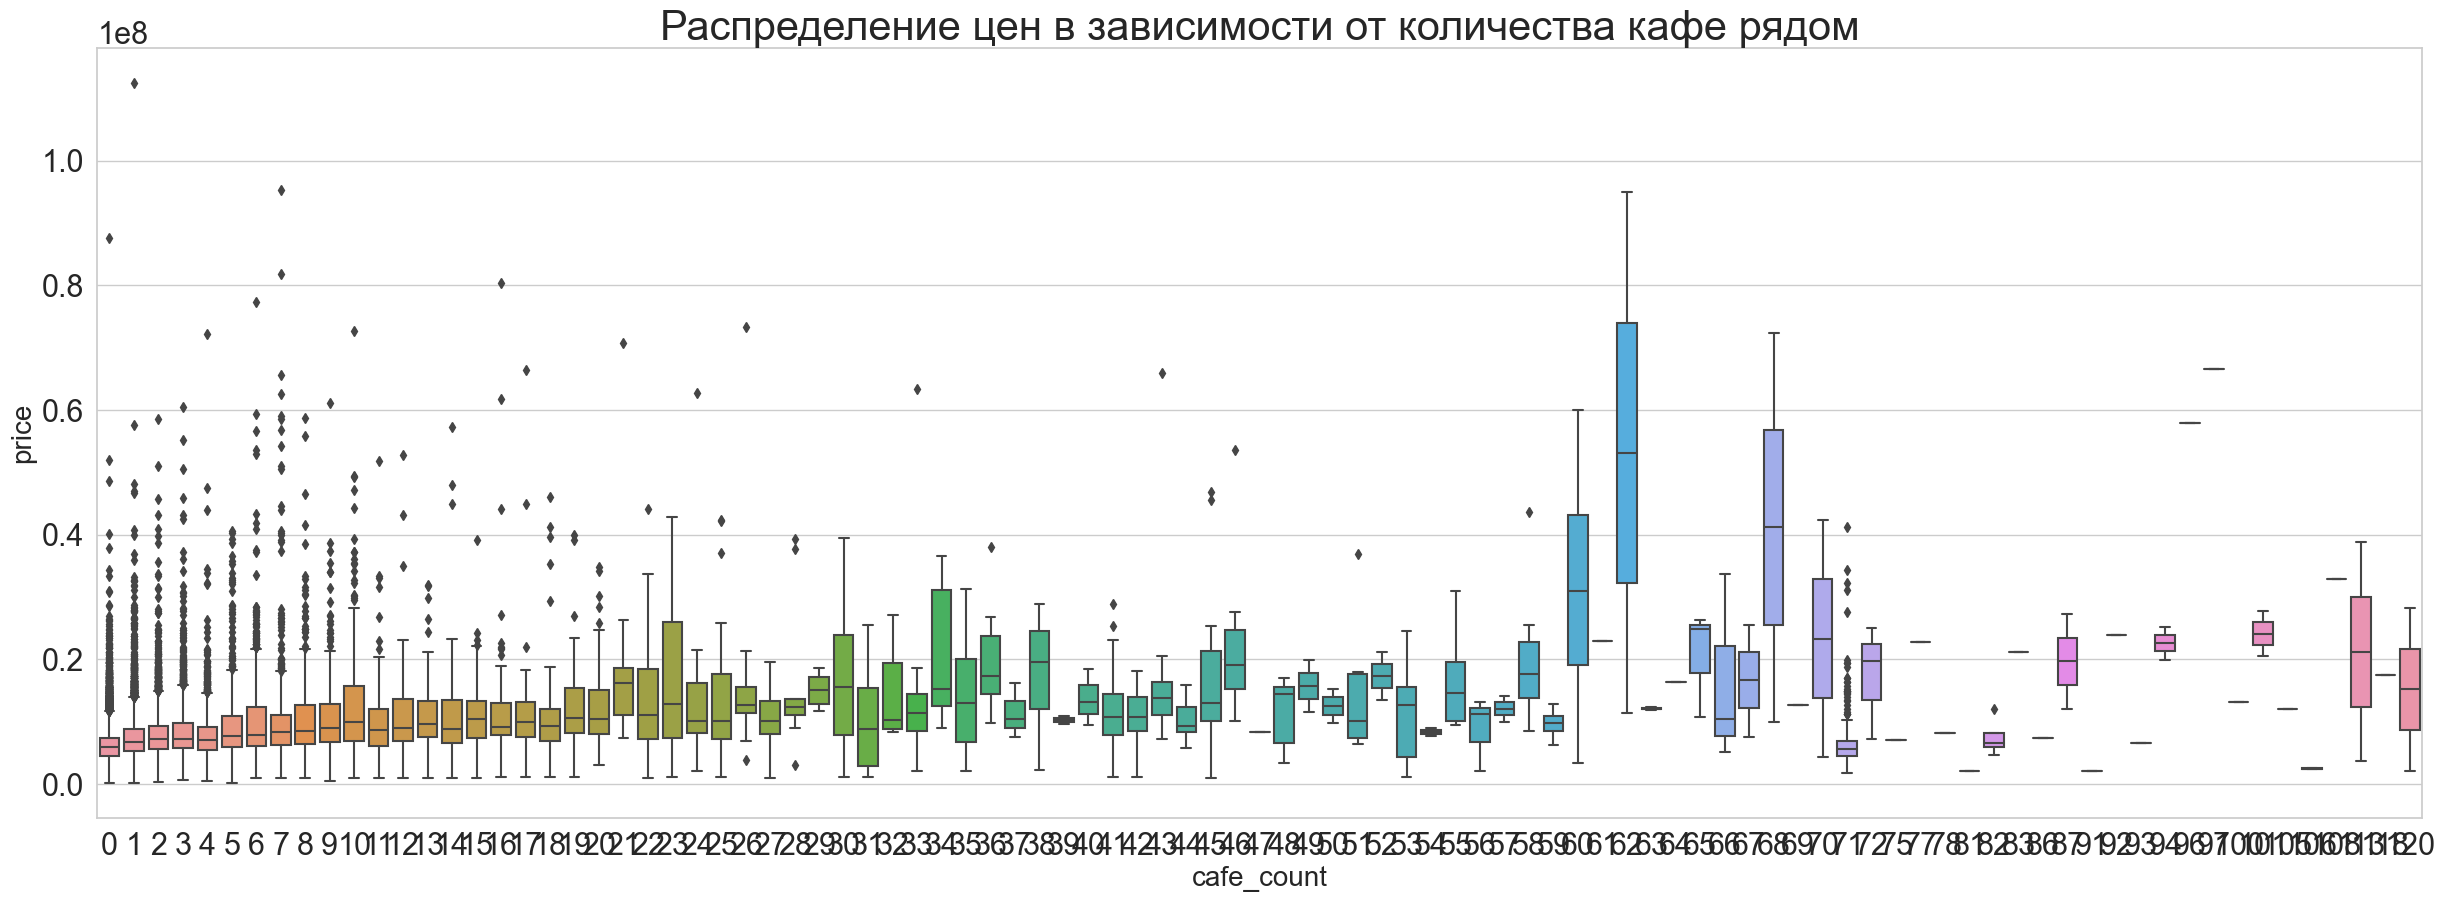

In [25]:
plt.figure(figsize=(30, 10));
sns.boxplot(x='cafe_count', y='price', data=full_train_data);
plt.title('Распределение цен в зависимости от количества кафе рядом', fontsize=30)
plt.ylabel('price', fontsize=20)
plt.xlabel('cafe_count', fontsize=20)
plt.show()

In [26]:
full_train_data['year'] = full_train_data.timestamp.dt.year
full_train_data['month'] = full_train_data.timestamp.dt.month

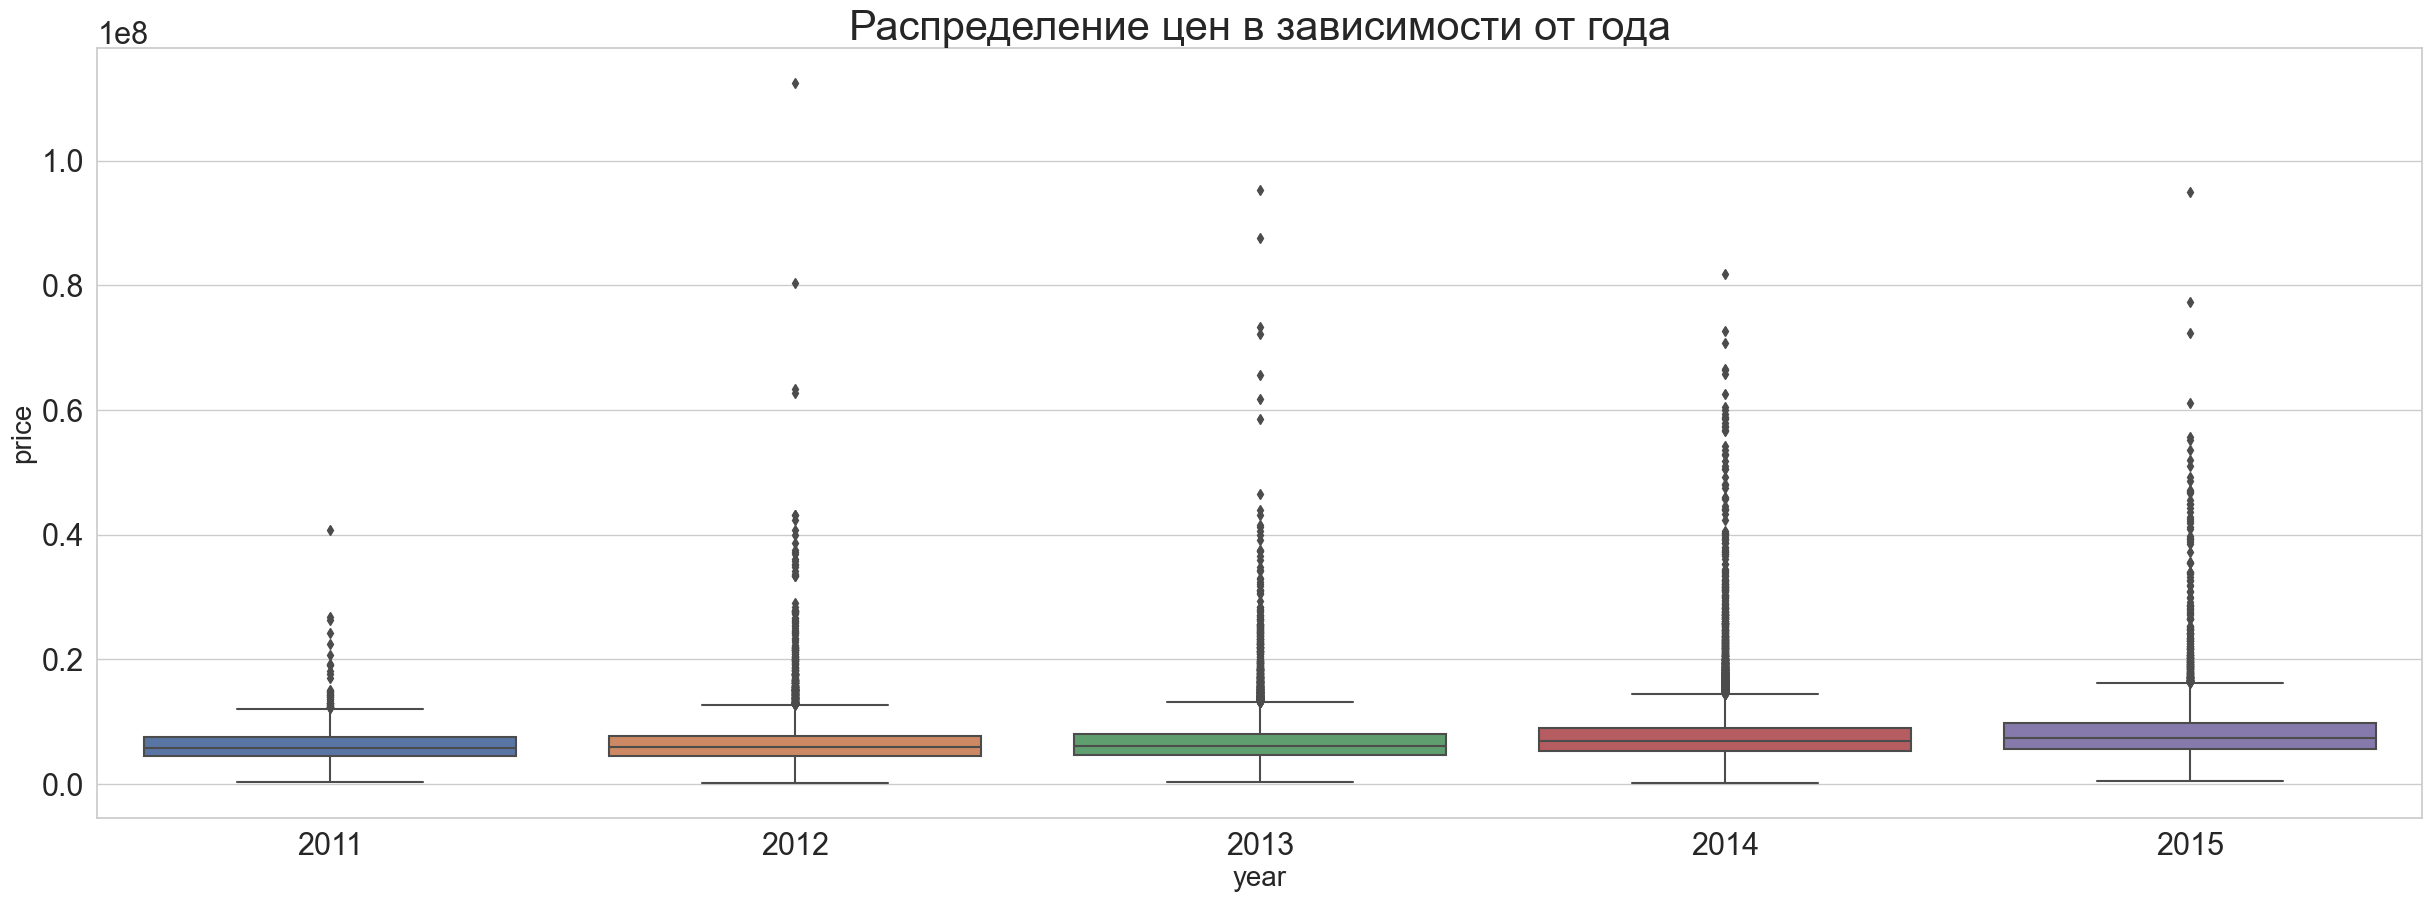

In [27]:
plt.figure(figsize=(30, 10));
sns.boxplot(x='year', y='price', data=full_train_data);
plt.title('Распределение цен в зависимости от года', fontsize=30)
plt.ylabel('price', fontsize=20)
plt.xlabel('year', fontsize=20)
plt.show()

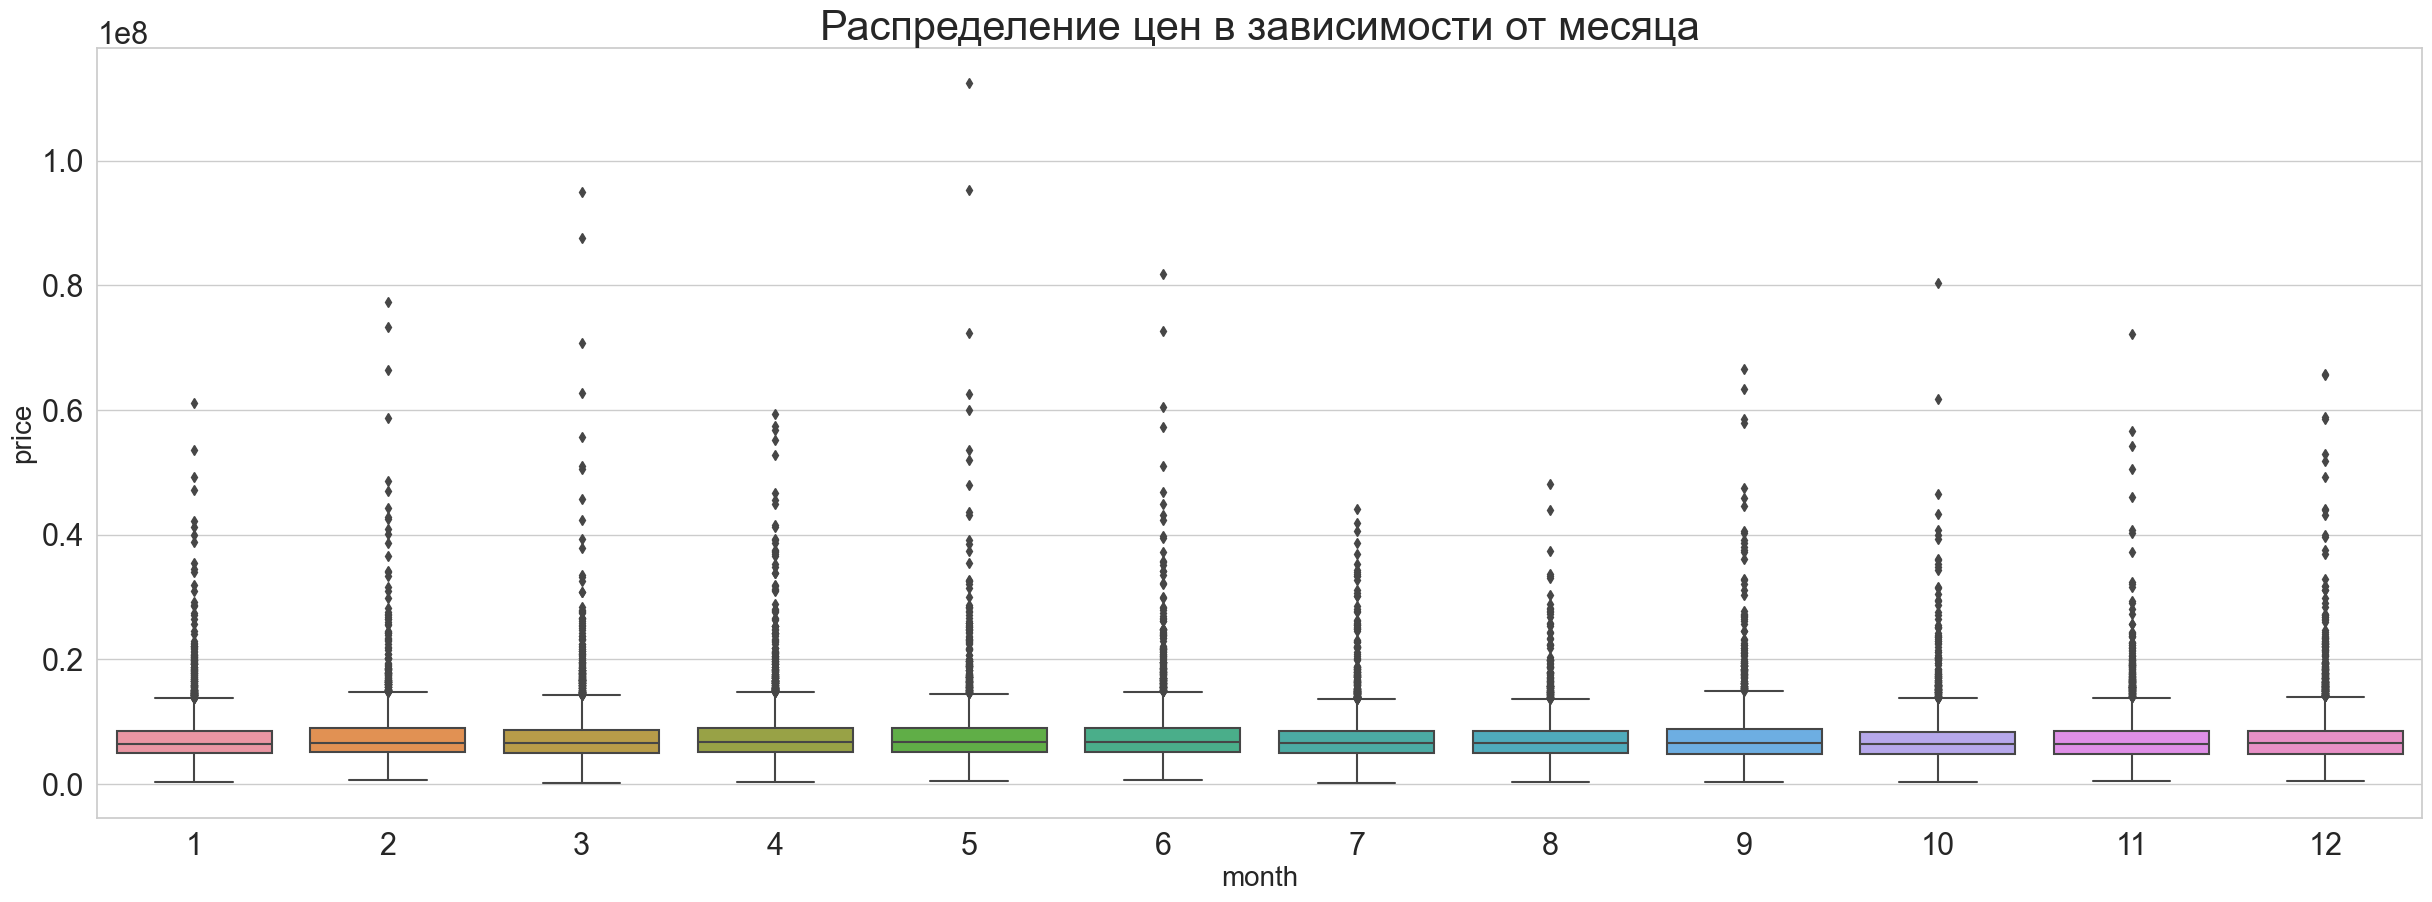

In [28]:
plt.figure(figsize=(30, 10));
sns.boxplot(x='month', y='price', data=full_train_data);
plt.title('Распределение цен в зависимости от месяца', fontsize=30)
plt.ylabel('price', fontsize=20)
plt.xlabel('month', fontsize=20)
plt.show()

In [29]:
full_train_data['year_month'] = full_train_data.timestamp.apply(lambda x: x.strftime('%Y-%m')).astype(str) 

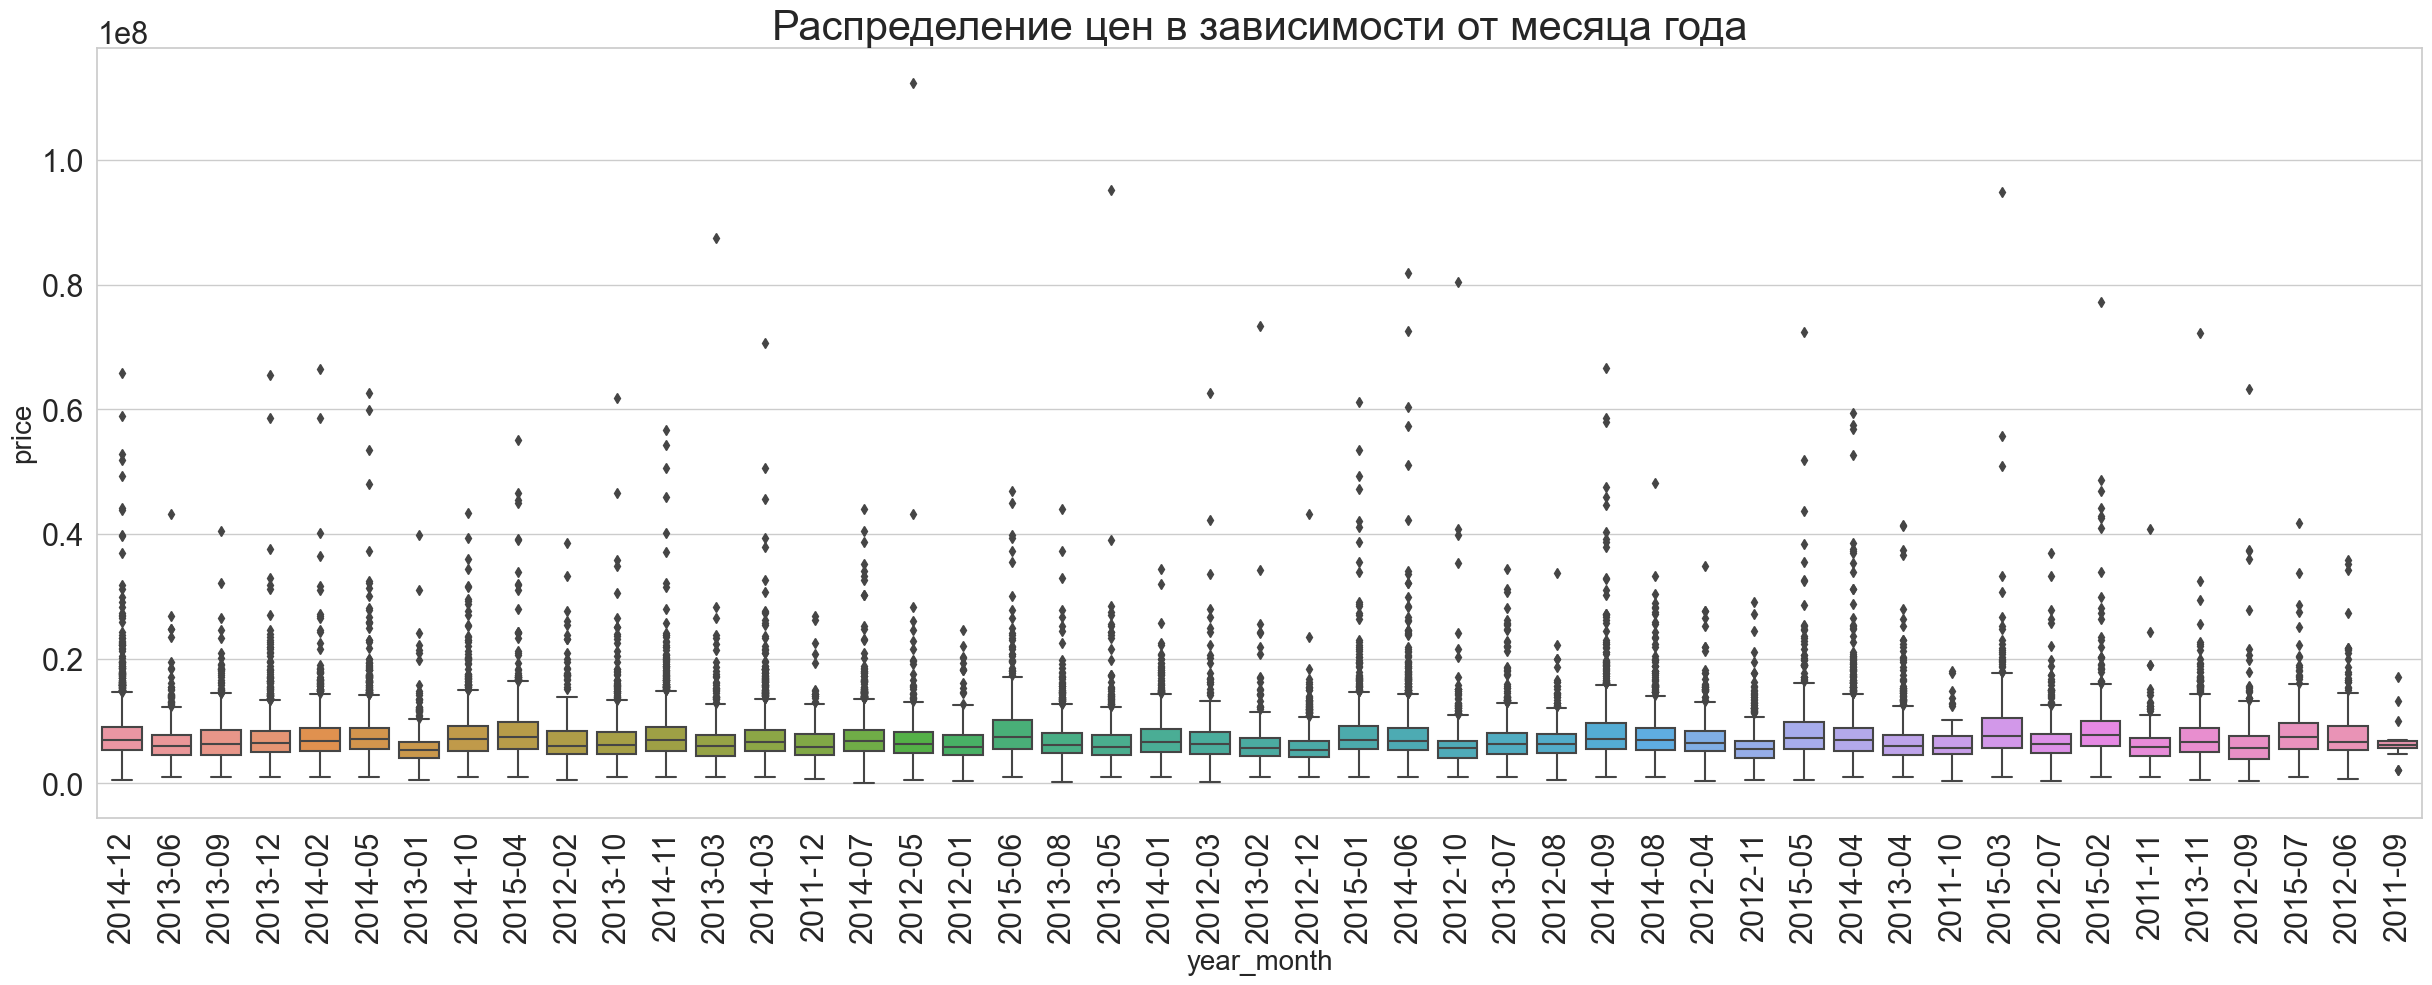

In [30]:
plt.figure(figsize=(30, 10));
sns.boxplot(x='year_month', y='price', data=full_train_data);
plt.title('Распределение цен в зависимости от месяца года', fontsize=30)
plt.ylabel('price', fontsize=20)
plt.xlabel('year_month', fontsize=20)
plt.xticks(rotation = 'vertical')
plt.show()

In [15]:
full_train_data.isnull().sum()/ full_train_data.shape[0]

id                                 0.000000
timestamp                          0.000000
full_sq                            0.000000
life_sq                            0.209138
floor                              0.005414
max_floor                          0.314241
material                           0.314241
build_year                         0.446241
num_room                           0.314241
kitch_sq                           0.314241
apartment condition                0.445241
sub_area                           0.000000
price                              0.000000
population                         0.000000
indust_part                        0.000000
preschool_facilities               0.000000
school_facilities                  0.000000
hospital_beds_raion                0.474034
healthcare_facilities              0.000000
university_num                     0.000000
sport_objects_facilities           0.000000
additional_education_facilities    0.000000
culture_objects_facilities      

In [128]:
full_test_data = test_main_data.merge(test_additional_data, how= 'inner', on = 'id')

In [62]:
full_train_data.describe().applymap(lambda x: f"{x:0.3f}")

id    full_sq    life_sq      floor  max_floor   material  \
count  29000.000  29000.000  22935.000  28843.000  19887.000  19887.000   
mean   54932.810     55.235     34.103      7.665     12.561      1.821   
std    25981.969     38.781     20.911      5.320      6.775      1.475   
min    10001.000      0.000      0.000      0.000      0.000      1.000   
25%    32382.500     40.000     20.000      3.000      9.000      1.000   
50%    54984.500     50.000     30.000      6.000     12.000      1.000   
75%    77417.500     64.000     43.000     11.000     17.000      2.000   
max    99999.000   5329.000    802.000     77.000    117.000      6.000   

         build_year   num_room   kitch_sq apartment condition   sub_area  \
count     16059.000  19887.000  19887.000           16088.000  29000.000   
mean       3126.422      1.908      6.424               2.108     76.504   
std      158219.399      0.853     28.961               0.882     39.308   
min           0.000      0.000      0.000               1.000      0.000   
25%        1966.000      1.000      1.000               1.000     44.000   
50%        1979.000      2.000      6.000               2.000     78.000   
75%        2005.000      2.000      9.000               3.000    105.000   
max    20052009.000     19.000   2014.000              33.000    145.000   

               price  population indust_part preschool_facilities  \
count      29000.000   29000.000   29000.000            29000.000   
mean     7472051.348   84061.315       0.119                4.066   
std      5056735.762   57811.852       0.119                2.991   
min       108500.000    2546.000       0.000                0.000   
25%      4957875.000   21819.000       0.020                2.000   
50%      6553400.000   83502.000       0.072                4.000   
75%      8674925.000  122862.000       0.196                6.000   
max    112444400.000  247469.000       0.522               13.000   

      school_facilities hospital_beds_raion healthcare_facilities  \
count         29000.000           15253.000             29000.000   
mean              4.704            1190.744                 1.321   
std               3.441            1057.236                 1.492   
min               0.000               0.000                 0.000   
25%               2.000             520.000                 0.000   
50%               5.000             990.000                 1.000   
75%               7.000            1786.000                 2.000   
max              14.000            4849.000                 6.000   

      university_num sport_objects_facilities additional_education_facilities  \
count      29000.000                29000.000                       29000.000   
mean           0.139                    6.641                           2.897   
std            0.445                    6.584                           3.292   
min            0.000                    0.000                           0.000   
25%            0.000                    1.000                           1.000   
50%            0.000                    5.000                           2.000   
75%            0.000                   10.000                           4.000   
max            3.000                   29.000                          16.000   

      culture_objects_facilities shopping_centers_facilities office_num  \
count                  29000.000                   29000.000  29000.000   
mean                       0.289                       4.207      8.300   
std                        1.519                       4.750     23.650   
min                        0.000                       0.000      0.000   
25%                        0.000                       1.000      0.000   
50%                        0.000                       3.000      2.000   
75%                        0.000                       6.000      5.000   
max                       10.000                      23.000    141.000   

   

In [63]:
full_test_data.describe()

id      full_sq      life_sq       floor   max_floor  \
count   1000.000000  1000.000000   797.000000  995.000000  688.000000   
mean   54982.245000    54.196000    43.037641    7.901508   12.521802   
std    25884.093699    18.820728   264.380486    5.420390    6.331878   
min    10114.000000     2.000000     1.000000    1.000000    0.000000   
25%    32023.500000    39.000000    20.000000    3.000000    9.000000   
50%    55393.500000    50.500000    30.000000    7.000000   12.000000   
75%    77627.000000    65.000000    43.000000   11.000000   17.000000   
max    99787.000000   151.000000  7478.000000   26.000000   36.000000   

         material   build_year    num_room    kitch_sq  apartment condition  \
count  688.000000   559.000000  688.000000  688.000000           565.000000   
mean     2.026163  1917.082290    1.938953    6.014535             2.100885   
std      1.635456   360.430612    0.837126    4.205399             0.837136   
min      1.000000     0.000000    1.000000    0.000000             1.000000   
25%      1.000000  1967.000000    1.000000    1.000000             1.000000   
50%      1.000000  1979.000000    2.000000    6.000000             2.000000   
75%      2.000000  2004.500000    3.000000    9.000000             3.000000   
max      6.000000  2017.000000    6.000000   41.000000             4.000000   

          sub_area     population  indust_part  preschool_facilities  \
count  1000.000000    1000.000000  1000.000000           1000.000000   
mean     76.115000   85545.639000     0.115138              4.137000   
std      38.559235   59707.295673     0.117816              3.066861   
min       0.000000    2546.000000     0.000000              0.000000   
25%      43.000000   21819.000000     0.017647              2.000000   
50%      75.000000   83844.000000     0.072158              4.000000   
75%     105.000000  123000.000000     0.188784              6.000000   
max     145.000000  247469.000000     0.521867             13.000000   

       school_facilities  hospital_beds_raion  healthcare_facilities  \
count        1000.000000           544.000000            1000.000000   
mean            4.807000          1196.753676               1.333000   
std             3.537268          1063.715855               1.486041   
min             0.000000            30.000000               0.000000   
25%             2.000000           350.000000               0.000000   
50%             5.000000          1015.000000               1.000000   
75%             7.000000          1894.000000               2.000000   
max            14.000000          4849.000000               6.000000   

       university_num  sport_objects_facilities  \
count     1000.000000               1000.000000   
mean         0.137000                  6.739000   
std          0.443201                  6.484978   
min          0.000000                  0.000000   
25%          0.000000                  1.000000   
50%          0.000000                  6.000000   
75%          0.000000                 10.000000   
max          3.000000                 29.000000   

       additional_education_facilities  culture_objects_facilities  \
count                      1000.000000                 1000.000000   
mean                          2.972000                    0.264000   
std                           3.344907                    1.387166   
min                           0.000000                    0.000000   
25%                           1.000000                    0.000000   
50%                           2.000000                    0.000000   
75%                           4.000000                    0.000000   
max                          16.000000                   10.000000   

       shopping_centers_facilities   office_num   green_part   prom_part  \
count                  1000.000000  1000.000000  1000.000000  1000.00000   
mean                      4.125000     7.799000    13.741470     5.90119   
std                       4.64

выбросы и в тестовом, избавлюсь от выбросов только в тех колонках train в которых есть в тестовом: 
full_sq, floor, max_floor, build_year, num_room, kitch_sq, apartment condition, cafe_count

C:\Users\keybi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

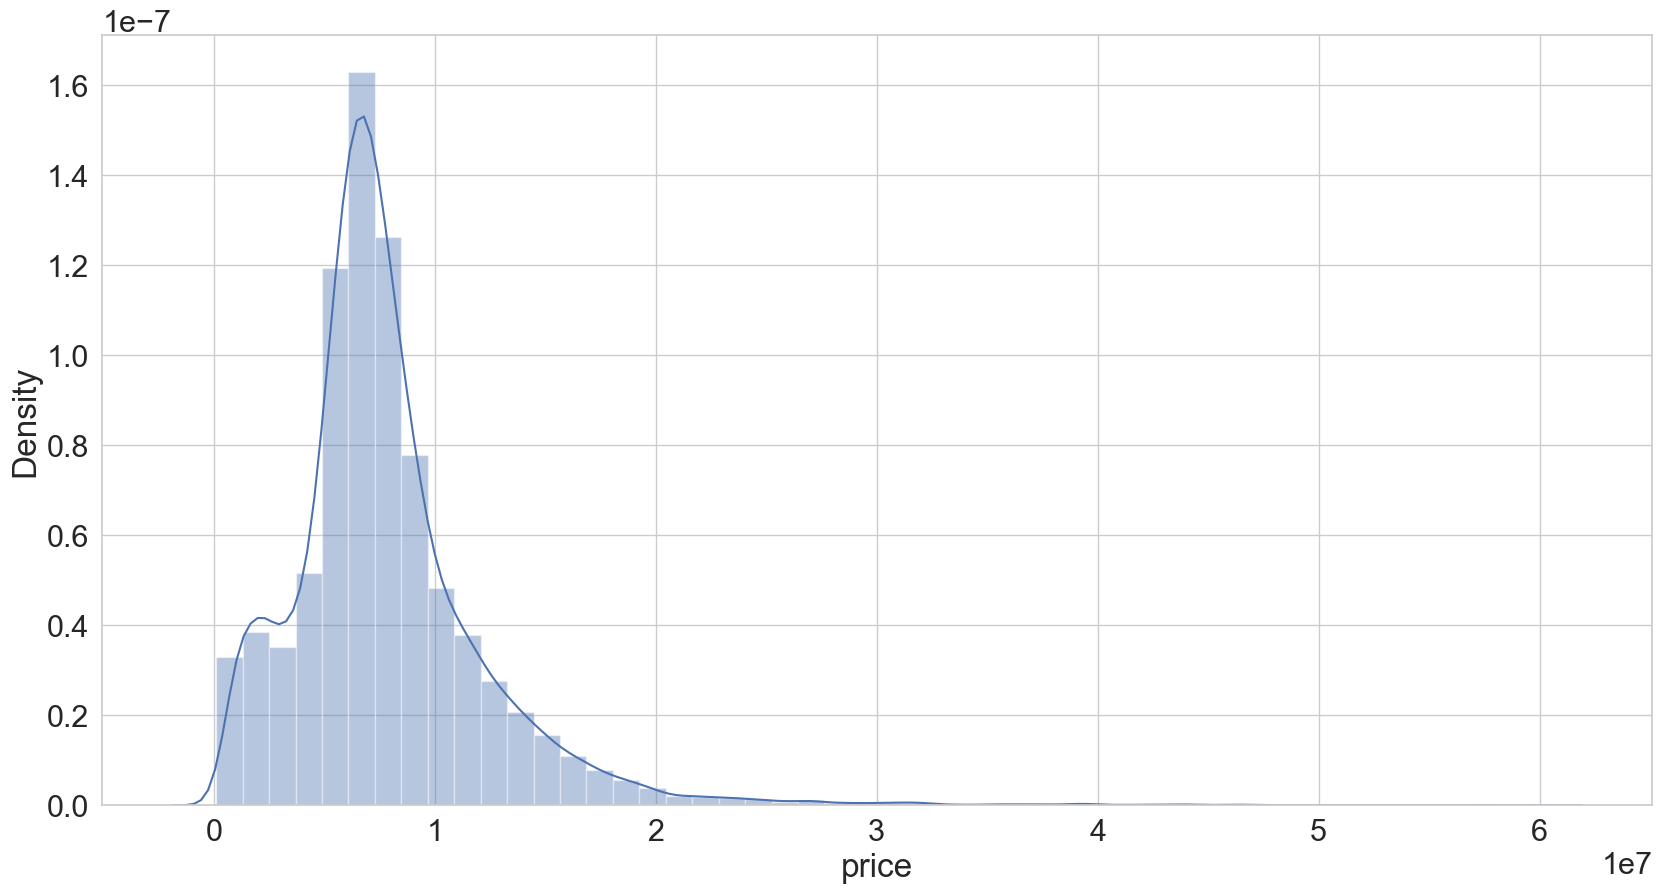

In [84]:
sns.distplot(full_train_data['price'])

# Preprocessing data

In [103]:
full_train_data = full_train_data[(full_train_data['full_sq'] <= 200)].reset_index(drop = True) #по верхней границе

In [104]:
full_train_data = full_train_data[(full_train_data['floor'] <= 30)].reset_index(drop = True)
full_train_data = full_train_data[(full_train_data['max_floor'] <= 40)].reset_index(drop = True)
full_train_data = full_train_data[(full_train_data['build_year'] <= 2017)].reset_index(drop = True)
full_train_data = full_train_data[(full_train_data['num_room'] <= 8)].reset_index(drop = True)
full_train_data = full_train_data[(full_train_data['kitch_sq'] <= 50)].reset_index(drop = True)
full_train_data = full_train_data[(full_train_data['apartment condition'] < 4)].reset_index(drop = True)
full_train_data = full_train_data[(full_train_data['cafe_count'] <= 72)].reset_index(drop = True)
full_train_data.shape

(14041, 31)

In [105]:
full_train_data

id  timestamp  full_sq  life_sq  floor  max_floor  material  \
0      30392 2014-12-30       60     36.0    6.0        9.0       1.0   
1      17531 2013-12-13       33     18.0    4.0        9.0       1.0   
2      32159 2014-02-13       37     14.0    1.0       17.0       1.0   
3      63050 2014-05-08       44      1.0   10.0       25.0       2.0   
4      27294 2014-10-25      137      NaN   18.0       18.0       1.0   
...      ...        ...      ...      ...    ...        ...       ...   
14036  40364 2014-04-09       31     20.0    7.0        9.0       5.0   
14037  48115 2014-12-18       50     34.0    4.0        9.0       1.0   
14038  55519 2013-09-23       55     30.0    9.0       16.0       1.0   
14039  17196 2013-11-19       37     19.0    3.0       16.0       5.0   
14040  97330 2014-05-03       45     20.0   12.0       17.0       6.0   

       build_year  num_room  kitch_sq  ...  additional_education_facilities  \
0          1974.0       3.0       5.0  ...                                3   
1          1970.0       1.0       6.0  ...                                4   
2          1991.0       1.0       1.0  ...                                4   
3          2014.0       1.0       1.0  ...                               16   
4          2014.0       3.0       1.0  ...                                2   
...           ...       ...       ...  ...                              ...   
14036      1965.0       1.0       5.0  ...                                8   
14037      1967.0       3.0       6.0  ...                                1   
14038      2002.0       2.0       8.0  ...                                4   
14039      1979.0       1.0       9.0  ...                                3   
14040      2011.0       1.0      10.0  ...                                3   

       culture_objects_facilities  shopping_centers_facilities  office_num  \
0                               0                           16           1   
1                               0                            2           0   
2                               0                            1           0   
3                              10                           23         141   
4                               0                            1           1   
...                           ...                          ...         ...   
14036                           0                            5           1   
14037                           1                            3           0   
14038                           0                            4           4   
14039                           0                           11           6   
14040                           0                            1           0   

       green_part  prom_part  cafe_count  church_facilities  mosque  \
0            2.86       0.00           0                  0       0   
1            7.46       0.00           1                  0       0   
2            0.00       0.00           3                  0       0   
3           12.24       0.00          71                 15       0   
4            9.22       2.14           7                  0       0   
...           ...        ...         ...                ...     ...   
14036        0.00       0.33           1                  0       0   
14037        3.90       0.00           1                  0       0   
14038       12.32       0.00           0                  0       0   
14039       39.80       7.01           3                  0       0   
14040        1.40      16.74           0                  0       0   

       leisure_facilities  
0                       0  
1                       0  
2                       0  
3                       0  
4                       0  
...                   ...  
14036                   0  
14037                   0  
14038                   0  
14039                   0  
14040                   0  

[14041 rows x 31 columns]

In [15]:
#full_train_data['age'] = full_train_data['year'] - full_train_data['build_year']

In [15]:
#full_train_data['age']

0        40.0
1        43.0
2        23.0
3         0.0
4         0.0
         ... 
13813    49.0
13814    47.0
13815    11.0
13816    34.0
13817     3.0
Name: age, Length: 13818, dtype: float64

In [104]:
full_train_data.drop_duplicates(inplace=True)

In [17]:
#full_train_data['educations'] = full_train_data['university_num'] + full_train_data['preschool_facilities'] + \
#full_train_data['school_facilities']

In [18]:
#full_train_data['educations']

0        10
1         9
2        14
3        10
4         8
         ..
13813    16
13814    13
13815    24
13816    10
13817     0
Name: educations, Length: 13818, dtype: int64

In [201]:
full_train_data.isnull().sum()/ full_train_data.shape[0]  

id                                 0.000000
timestamp                          0.000000
full_sq                            0.000000
life_sq                            0.030624
floor                              0.000000
max_floor                          0.000000
material                           0.000000
build_year                         0.000000
num_room                           0.000000
kitch_sq                           0.000000
apartment condition                0.000000
sub_area                           0.000000
price                              0.000000
population                         0.000000
indust_part                        0.000000
preschool_facilities               0.000000
school_facilities                  0.000000
hospital_beds_raion                0.426374
healthcare_facilities              0.000000
university_num                     0.000000
sport_objects_facilities           0.000000
additional_education_facilities    0.000000
culture_objects_facilities      

In [200]:
full_test_data.isnull().sum()/ full_test_data.shape[0]  

id                                 0.000
timestamp                          0.000
full_sq                            0.000
life_sq                            0.203
floor                              0.005
max_floor                          0.312
material                           0.312
build_year                         0.441
num_room                           0.312
kitch_sq                           0.312
apartment condition                0.435
sub_area                           0.000
population                         0.000
indust_part                        0.000
preschool_facilities               0.000
school_facilities                  0.000
hospital_beds_raion                0.456
healthcare_facilities              0.000
university_num                     0.000
sport_objects_facilities           0.000
additional_education_facilities    0.000
culture_objects_facilities         0.000
shopping_centers_facilities        0.000
office_num                         0.000
green_part      

In [199]:
(full_train_data.corr())['price'].sort_values(ascending = False)


price                              1.000000
full_sq                            0.623254
num_room                           0.488451
life_sq                            0.435821
sport_objects_facilities           0.253616
kitch_sq                           0.209081
office_num                         0.192634
university_num                     0.178392
school_facilities                  0.152856
cafe_count                         0.147744
shopping_centers_facilities        0.146633
healthcare_facilities              0.143646
floor                              0.132762
leisure_facilities                 0.130209
max_floor                          0.128068
preschool_facilities               0.116683
population                         0.101488
hospital_beds_raion                0.080671
culture_objects_facilities         0.076887
build_year                         0.060374
apartment condition                0.056521
additional_education_facilities    0.050452
church_facilities               

In [129]:
full_test_data['timestamp'] = pd.to_datetime(full_test_data['timestamp'])

full_test_data['year'] = full_test_data.timestamp.dt.year
full_test_data['month'] = full_test_data.timestamp.dt.month

In [40]:
#full_test_data['year_month'] = full_test_data.timestamp.apply(lambda x: x.strftime('%Y-%m')).astype(str)  

In [20]:
#full_test_data['educations'] = full_test_data['university_num'] + full_test_data['preschool_facilities'] + \
#full_test_data['school_facilities']

In [82]:
full_test_data.shape

(1000, 34)

In [79]:
#full_train_data['log_price'] = np.log(full_train_data['price'])

In [21]:
#full_test_data['age'] = full_test_data['year'] - full_test_data['build_year']

bins = [5, 15, 25, 35, 45 ,55,65,75,85,95,105,115,125,135,145]
full_train_data['full_sq_bins'] = np.searchsorted(bins, full_train_data.full_sq.values)
full_test_data['full_sq_bins'] = np.searchsorted(bins, full_test_data.full_sq.values)

In [130]:
full_data = pd.concat([full_train_data, full_test_data], axis=0)
full_data

id  timestamp  full_sq  life_sq  floor  max_floor  material  \
0    30392 2014-12-30       60     36.0    6.0        9.0       1.0   
1    36540 2013-06-28       44     29.0    9.0        NaN       NaN   
2    94669 2013-09-15       62     60.0    4.0        NaN       NaN   
3    17531 2013-12-13       33     18.0    4.0        9.0       1.0   
4    32159 2014-02-13       37     14.0    1.0       17.0       1.0   
..     ...        ...      ...      ...    ...        ...       ...   
995  28684 2015-04-05       54      NaN    2.0       17.0       1.0   
996  65212 2014-05-22       78     45.0    5.0       10.0       1.0   
997  11218 2014-12-18        2      1.0   26.0        1.0       1.0   
998  57238 2013-06-09       55     33.0    6.0        NaN       NaN   
999  26048 2014-06-12       41      NaN    8.0       17.0       1.0   

     build_year  num_room  kitch_sq  ...  additional_education_facilities  \
0        1974.0       3.0       5.0  ...                                3   
1           NaN       NaN       NaN  ...                                3   
2           NaN       NaN       NaN  ...                                2   
3        1970.0       1.0       6.0  ...                                4   
4        1991.0       1.0       1.0  ...                                4   
..          ...       ...       ...  ...                              ...   
995         NaN       2.0       1.0  ...                                0   
996      1995.0       3.0      10.0  ...                               16   
997         1.0       1.0       1.0  ...                                0   
998         NaN       NaN       NaN  ...                                3   
999         NaN       1.0       1.0  ...                                4   

     culture_objects_facilities  shopping_centers_facilities  office_num  \
0                             0                           16           1   
1                             0                           11           5   
2                             0                            4           2   
3                             0                            2           0   
4                             0                            1           0   
..                          ...                          ...         ...   
995                           0                            0           0   
996                           0                           15           2   
997                           0                            7           2   
998                           0                           16           1   
999                           0                            0           0   

     green_part  prom_part  cafe_count  church_facilities  mosque  \
0          2.86       0.00           0                  0       0   
1          9.26       2.71           1                  0       0   
2         13.80       0.00           4                  0       0   
3          7.46       0.00           1                  0       0   
4          0.00       0.00           3                  0       0   
..          ...        ...         ...                ...     ...   
995        0.00       0.00           0                  0       0   
996       13.84       0.00           6                  0       0   
997        2.07      20.49           3                  0       0   
998       17.62       0.00           4                  0       0   
999       42.63       5.76           0                  0       0   

     leisure_facilities  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
..                  ...  
995                   0  
996                   0  
997                   0  
998                   0  
999                   0  

[30000 rows x 31 columns]

In [131]:
mice_imputer = IterativeImputer()
full_data['life_sq'] = mice_imputer.fit_transform(full_data[['life_sq']])

In [132]:
full_data['floor'] = mice_imputer.fit_transform(full_data[['floor']])
full_data['max_floor'] = mice_imputer.fit_transform(full_data[['max_floor']])
full_data['material'] = mice_imputer.fit_transform(full_data[['material']])
full_data['build_year'] = mice_imputer.fit_transform(full_data[['build_year']])
full_data['num_room'] = mice_imputer.fit_transform(full_data[['num_room']])
full_data['kitch_sq'] = mice_imputer.fit_transform(full_data[['kitch_sq']])
full_data['apartment condition'] = mice_imputer.fit_transform(full_data[['apartment condition']])

In [134]:
#full_data['year'] = full_data.timestamp.dt.year
#full_data['month'] = full_data.timestamp.dt.month

In [135]:
full_data['age'] = full_data['year'] - full_data['build_year']
full_data['educations'] = full_data['university_num'] + full_data['preschool_facilities'] + \
full_data['school_facilities']

In [136]:
bins = [5, 15, 25, 35, 45 ,55,65,75,85,95,105,115,125,135,145]
full_data['full_sq_bins'] = np.searchsorted(bins, full_data.full_sq.values)

In [133]:
full_data.isnull().sum()/ full_data.shape[0]  

id                                 0.000000
timestamp                          0.000000
full_sq                            0.000000
life_sq                            0.000000
floor                              0.000000
max_floor                          0.000000
material                           0.000000
build_year                         0.000000
num_room                           0.000000
kitch_sq                           0.000000
apartment condition                0.000000
sub_area                           0.000000
price                              0.033333
population                         0.000000
indust_part                        0.000000
preschool_facilities               0.000000
school_facilities                  0.000000
hospital_beds_raion                0.473433
healthcare_facilities              0.000000
university_num                     0.000000
sport_objects_facilities           0.000000
additional_education_facilities    0.000000
culture_objects_facilities      

In [116]:
full_data[14041:]

id  timestamp  full_sq  life_sq  floor  max_floor  material  \
0    30307 2014-04-20       74     43.0   13.0       14.0       1.0   
1    87380 2015-01-17       29     40.6    6.0       17.0       1.0   
2    12874 2014-07-08       80     38.2    8.0       17.0       1.0   
3    57688 2013-01-15       53     34.0    4.0       14.6       1.0   
4    43433 2012-06-15       36     19.0   16.0       13.8       2.6   
..     ...        ...      ...      ...    ...        ...       ...   
995  28684 2015-04-05       54     31.0    2.0       17.0       1.0   
996  65212 2014-05-22       78     45.0    5.0       10.0       1.0   
997  11218 2014-12-18        2      1.0   26.0        1.0       1.0   
998  57238 2013-06-09       55     33.0    6.0       14.4       1.0   
999  26048 2014-06-12       41     12.8    8.0       17.0       1.0   

     build_year  num_room  kitch_sq  ...  prom_part  cafe_count  \
0        1996.0       3.0      10.0  ...       0.00           5   
1        1612.4       1.0       1.0  ...       2.78           0   
2        1208.6       3.0       1.0  ...       2.83           1   
3        1985.0       2.0       8.2  ...       0.00           4   
4        1996.4       1.8       8.4  ...       0.00           4   
..          ...       ...       ...  ...        ...         ...   
995      2015.0       2.0       1.0  ...       0.00           0   
996      1995.0       3.0      10.0  ...       0.00           6   
997         1.0       1.0       1.0  ...      20.49           3   
998      1985.8       2.0       8.0  ...       0.00           4   
999      2012.6       1.0       1.0  ...       5.76           0   

     church_facilities  mosque  leisure_facilities  year  month     age  \
0                    0       0                   0  2014      4    18.0   
1                    0       0                   0  2015      1   402.6   
2                    0       0                   0  2014      7   805.4   
3                    0       0                   0  2013      1    28.0   
4                    1       0                   0  2012      6    15.6   
..                 ...     ...                 ...   ...    ...     ...   
995                  0       0                   0  2015      4     0.0   
996                  0       0                   0  2014      5    19.0   
997                  0       0                   0  2014     12  2013.0   
998                  0       0                   0  2013      6    27.2   
999                  0       0                   0  2014      6     1.4   

     educations  full_sq_bins  
0            27             7  
1             0             3  
2             0             8  
3            12             5  
4             8             4  
..          ...           ...  
995           0             5  
996          27             8  
997           4             0  
998          10             5  
999          10             4  

[1000 rows x 36 columns]

In [137]:
full_test_data = full_data[29000:]
full_train_data = full_data[:29000]

In [20]:
full_train_data

id  timestamp  full_sq  life_sq  floor  max_floor  material  \
0      30392 2014-12-30       60     36.0    6.0        9.0       1.0   
1      36540 2013-06-28       44     29.0    9.0       12.2       1.0   
2      94669 2013-09-15       62     60.0    4.0       12.4       1.0   
3      17531 2013-12-13       33     18.0    4.0        9.0       1.0   
4      32159 2014-02-13       37     14.0    1.0       17.0       1.0   
...      ...        ...      ...      ...    ...        ...       ...   
28995  85589 2013-05-08       58     22.2    2.0       11.0       1.0   
28996  11345 2014-04-12       38     46.8    9.0       17.0       1.0   
28997  55519 2013-09-23       55     30.0    9.0       16.0       1.0   
28998  17196 2013-11-19       37     19.0    3.0       16.0       5.0   
28999  97330 2014-05-03       45     20.0   12.0       17.0       6.0   

       build_year  num_room  kitch_sq  ...  additional_education_facilities  \
0          1974.0       3.0       5.0  ...                                3   
1          1982.4       2.4       6.0  ...                                3   
2          1979.4       2.2       5.6  ...                                2   
3          1970.0       1.0       6.0  ...                                4   
4          1991.0       1.0       1.0  ...                                4   
...           ...       ...       ...  ...                              ...   
28995      1194.2       2.2       7.8  ...                                3   
28996      2013.4       1.0       1.0  ...                               16   
28997      2002.0       2.0       8.0  ...                                4   
28998      1979.0       1.0       9.0  ...                                3   
28999      2011.0       1.0      10.0  ...                                3   

       culture_objects_facilities  shopping_centers_facilities  office_num  \
0                               0                           16           1   
1                               0                           11           5   
2                               0                            4           2   
3                               0                            2           0   
4                               0                            1           0   
...                           ...                          ...         ...   
28995                           0                            1           0   
28996                          10                           23         141   
28997                           0                            4           4   
28998                           0                           11           6   
28999                           0                            1           0   

       green_part  prom_part  cafe_count  church_facilities  mosque  \
0            2.86       0.00           0                  0       0   
1            9.26       2.71           1                  0       0   
2           13.80       0.00           4                  0       0   
3            7.46       0.00           1                  0       0   
4            0.00       0.00           3                  0       0   
...           ...        ...         ...                ...     ...   
28995        9.26       7.02           0                  0       0   
28996       12.24       0.00          71                 15       0   
28997       12.32       0.00           0                  0       0   
28998       39.80       7.01           3                  0       0   
28999        1.40      16.74           0                  0       0   

       leisure_facilities  
0                       0  
1                       0  
2                       0  
3                       0  
4                       0  
...                   ...  
28995                   0  
28996                   0  
28997                   0  
28998                   0  
28999                   0  

[29000 rows x 31 columns]

# Model

### используемые feature

In [138]:
col = ['full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'num_room', 'kitch_sq', 'apartment condition', 'sub_area', \
       'population', 'indust_part', 'healthcare_facilities', 'sport_objects_facilities', 'additional_education_facilities', \
      'culture_objects_facilities', 'shopping_centers_facilities', 'office_num', 'green_part', 'prom_part', 'cafe_count', \
      'year', 'month', 'age', 'educations', 'full_sq_bins']

In [139]:
X_train, X_test, y_train, y_test  = train_test_split(full_train_data[col], full_train_data['price'], test_size = 2000, \
                                                     random_state=42)
# {'iterations': 600, 'learning_rate': 0.05, 'depth': 6} {'iterations': 475, 'learning_rate': 0.05, 'depth': 8, 'random_state': 0}

In [90]:
cat_model2 = CatBoostRegressor(iterations=1000,
                          grow_policy = 'Depthwise',
                          depth=8,
                          loss_function='RMSE',
                          random_state=0,
                          l2_leaf_reg = 2,
                          learning_rate=0.08,
                          verbose=400)

In [91]:
cat_model2.fit(X_train, y_train)

0:	learn: 4823448.4537156	total: 56.8ms	remaining: 56.7s
400:	learn: 1364255.3236471	total: 19s	remaining: 28.4s
800:	learn: 876117.7729720	total: 35.7s	remaining: 8.87s
999:	learn: 727090.8329881	total: 43.8s	remaining: 0us


In [92]:
pred = cat_model2.predict(X_test)
rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))
print('RMSE: {:.2f}'.format(rmse))

RMSE: 2847639.74


In [51]:
pred4 = cat_model2.predict(full_test_data[col])

In [52]:
pred4.shape

(1000,)

submission = pd.concat([full_test_data['id'], pd.Series(pred4, name='predicted_price')], axis=1)
submission

submission.to_csv(DATA_DIR/"submission.csv", \
                  index=False, header=True)

In [40]:
def submit(model, X, ids, file_path):
    SalePrice = model.predict(X)
    submission = pd.DataFrame({"Id": ids, "SalePrice": SalePrice.reshape(-1)})
    submission.to_csv(file_path, index=False)

In [120]:
parameters = {
    "depth": [ 6, 7, 8, 9, 10, 11, 12],
    "learning_rate": [0.05, 0.06, 0.08],
    "iterations": [450, 475, 500, 600, 700, 800, 900],
    "random_state": [0, 10, 20, 42, 50]
}

In [121]:
def evaluate(model, x_val, y_val):
    y_pred = model.predict(x_val)
    mse = metrics.mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    
    
    print("RMSE:", rmse)
    
    return {"rmse": rmse}

In [140]:
def train_with_catboost(hyperparameters, X_train, X_val, y_train, y_val):
    keys = hyperparameters.keys()
    best_index = {key:0 for key in keys}
    best_cat = None
    best_score = 10e7
    for (index, key) in enumerate(keys):
        print("Find best parameter for %s" %(key))
        items = hyperparameters[key]
        best_parameter = None
        temp_best = 10e7
        for (key_index, item) in enumerate(items):
            iterations = hyperparameters["iterations"][best_index["iterations"]] if key != "iterations" else item
            learning_rate = hyperparameters["learning_rate"][best_index["learning_rate"]] if key != "learning_rate" else item
            depth = hyperparameters["depth"][best_index["depth"]] if key != "depth" else item
            random_state = hyperparameters["random_state"][best_index["random_state"]] if key != "random_state" else item 
            print("Training with iterations: %d learning_rate: %.2f depth:%d"%(iterations, learning_rate, depth))
            cat = CatBoostRegressor(
                iterations = iterations, 
                learning_rate = learning_rate,
                depth = depth,
                verbose=500, random_state=random_state, loss_function='RMSE', l2_leaf_reg = 2, grow_policy = 'Depthwise' 
            )
            cat.fit(X_train, y_train, verbose=False)
            result = evaluate(cat, X_val, y_val)
            score = result["rmse"]
            if score < temp_best:
                temp_best = score
                best_index[key] = key_index
                best_parameter = item
            if score < best_score:
                best_score = score
                best_cat = cat
        print("Best Parameter for %s: "%(key), best_parameter)
    best_parameters = {
        "iterations": hyperparameters["iterations"][best_index["iterations"]],
        "learning_rate": hyperparameters["learning_rate"][best_index["learning_rate"]],
        "depth": hyperparameters["depth"][best_index["depth"]], 
        "random_state": hyperparameters["random_state"][best_index["random_state"]]
    }
    return best_cat, best_score, best_parameters
best_cat, best_score, best_parameters = train_with_catboost(parameters, X_train, X_test, y_train, y_test)

Find best parameter for depth
Training with iterations: 450 learning_rate: 0.05 depth:6
RMSE: 2599862.1675933134
Training with iterations: 450 learning_rate: 0.05 depth:7
RMSE: 2592042.5833321256
Training with iterations: 450 learning_rate: 0.05 depth:8
RMSE: 2589534.3003797713
Training with iterations: 450 learning_rate: 0.05 depth:9
RMSE: 2598128.3008293696
Training with iterations: 450 learning_rate: 0.05 depth:10
RMSE: 2591238.8284817687
Training with iterations: 450 learning_rate: 0.05 depth:11
RMSE: 2605839.5547584556
Training with iterations: 450 learning_rate: 0.05 depth:12
RMSE: 2607366.5721702785
Best Parameter for depth:  8
Find best parameter for learning_rate
Training with iterations: 450 learning_rate: 0.05 depth:8
RMSE: 2589534.3003797713
Training with iterations: 450 learning_rate: 0.06 depth:8
RMSE: 2684621.700628161
Training with iterations: 450 learning_rate: 0.08 depth:8
RMSE: 2629854.355228654
Best Parameter for learning_rate:  0.05
Find best parameter for iteratio

In [141]:
print("Best RMSE: ", best_score)
print("Best Parameters: ", best_parameters) #{'iterations': 500, 'learning_rate': 0.08, 'depth': 10}

Best RMSE:  2558368.947928076
Best Parameters:  {'iterations': 600, 'learning_rate': 0.05, 'depth': 8, 'random_state': 20}


In [75]:
X = pd.concat([X_train, X_test])
y = pd.concat([ y_train, y_test])
fold = 1
models = []
for train_indices, valid_indices in KFold(n_splits=5, shuffle=True,random_state=10).split(X):
    print("Training with Fold %d" % (fold))
    X_train = X.iloc[train_indices]
    X_test = X.iloc[valid_indices]
    y_train = y.iloc[train_indices]
    y_test = y.iloc[valid_indices]
    cat = CatBoostRegressor(
        iterations = best_parameters["iterations"], 
        learning_rate = best_parameters["learning_rate"],
        depth = best_parameters["depth"], 
        loss_function='RMSE', random_state=best_parameters["random_state"], 
        l2_leaf_reg = 2, grow_policy = 'Depthwise'
    )
    cat.fit(X_train, y_train, verbose=False)
    models.append(cat)
    evaluate(cat, X_test, y_test)
    fold += 1

Training with Fold 1
RMSE: 2818335.3552246806
Training with Fold 2
RMSE: 2546335.0879439106
Training with Fold 3
RMSE: 2686722.6338251038
Training with Fold 4
RMSE: 3264428.718612114
Training with Fold 5
RMSE: 2886895.70116455


In [77]:
pred7 = best_cat.predict(X_test)
rmse = np.sqrt(metrics.mean_squared_error(y_test, pred7))
print('RMSE: {:.2f}'.format(rmse)) #2566712.99 1820920.50

RMSE: 1820920.50


In [78]:
pred5 = best_cat.predict(full_test_data[col])#knn

In [142]:
pred8 = best_cat.predict(full_test_data[col])#inputer

In [143]:
pred6 = [(p5+p8)/2 for p5,p8 in zip(pred5, pred8)]#комбинация предсказаний на knn и inputer

In [146]:
submission = pd.concat([full_test_data['id'], pd.Series(pred8, name='predicted_price')], axis=1)
submission 

id  predicted_price
0    30307     1.022195e+07
1    87380     2.870714e+06
2    12874     8.911031e+06
3    57688     5.543859e+06
4    43433     5.443237e+06
..     ...              ...
995  28684     3.488811e+06
996  65212     1.098543e+07
997  11218     1.139038e+07
998  57238     7.328693e+06
999  26048     4.783533e+06

[1000 rows x 2 columns]

In [147]:
submission.to_csv(DATA_DIR/"submission.csv", \
                  index=False, header=True)

## Лучший скор RMSE = 2452734.0717.
### С помощью некомбинированной оценки из заполнения данных IterativeImputer() и подбора гиперпараметров в CatBoost
Сдано, граница LMS была RMSE = 2470000

# Черновик. 
то что было выше, но не подтвердило эффективность в данном случае

In [ ]:
def numeric(df):
    numeric_df = df.select_dtypes(np.number)
    return numeric_df

In [ ]:
def split_train_test(numeric_df, na_target):
    non_na_columns = numeric_df.loc[: , numeric_df.isna().sum() == 0].columns
    y_train = numeric_df.loc[numeric_df[na_target].isna() == False, na_target]
    X_train = numeric_df.loc[numeric_df[na_target].isna() == False, non_na_columns]
    X_test = numeric_df.loc[numeric_df[na_target].isna() == True, non_na_columns]
    return (y_train, X_train, X_test)

In [ ]:
knn = KNeighborsRegressor()
def knn_impute(df, na_target):
    df = df.copy()
    numeric_df = numeric(df)
    y_train, X_train, X_test = split_train_test(numeric_df, na_target)
    
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    
    df.loc[df[na_target].isna() == True, na_target] = y_pred
    
    return df

In [ ]:
for column in [
    'life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'kitch_sq', \
    'apartment condition'               
]:
    full_data = knn_impute(full_data, column)